## Reading Data and Importing Libraries ##

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import itertools    

In [2]:
# model
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from sklearn.metrics import *
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.nn.utils.rnn import PackedSequence
from torch.optim import lr_scheduler

try:
    from tensorflow.python.keras.callbacks import CallbackList
except ImportError:
    from tensorflow.python.keras._impl.keras.callbacks import CallbackList
    
from collections import OrderedDict, namedtuple, defaultdict
from itertools import chain

# -------------------------------------------------------------------------------------
# activation
class Dice(nn.Module):
    """The Data Adaptive Activation Function in DIN,which can be viewed as a generalization of PReLu and can adaptively adjust the rectified point according to distribution of input data.

    Input shape:
        - 2 dims: [batch_size, embedding_size(features)]
        - 3 dims: [batch_size, num_features, embedding_size(features)]

    Output shape:
        - Same shape as input.
    
    References
        - [Zhou G, Zhu X, Song C, et al. Deep interest network for click-through rate prediction[C]//Proceedings of the 24th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining. ACM, 2018: 1059-1068.](https://arxiv.org/pdf/1706.06978.pdf)
        - https://github.com/zhougr1993/DeepInterestNetwork, https://github.com/fanoping/DIN-pytorch
    """
    def __init__(self, emb_size, dim=2, epsilon=1e-8, device='cpu'):
        super(Dice, self).__init__()
        assert dim == 2 or dim == 3

        self.bn = nn.BatchNorm1d(emb_size, eps=epsilon)
        self.sigmoid = nn.Sigmoid()
        self.dim = dim

        if self.dim == 2:
            self.alpha = torch.zeros((emb_size,)).to(device)
        else:
            self.alpha = torch.zeros((emb_size, 1)).to(device)

    def forward(self, x):
        assert x.dim() == self.dim
        if self.dim == 2:
            x_p = self.sigmoid(self.bn(x))
            out = self.alpha * (1 - x_p) * x + x_p * x
        else:
            x = torch.transpose(x, 1, 2)
            x_p = self.sigmoid(self.bn(x))
            out = self.alpha * (1 - x_p) * x + x_p * x
            out = torch.transpose(out, 1, 2)
        
        return out


class Identity(nn.Module):


    def __init__(self, **kwargs):
        super(Identity, self).__init__()

    def forward(self, X):
        return X


def activation_layer(act_name, hidden_size=None, dice_dim=2):
    """Construct activation layers

    Args:
        act_name: str or nn.Module, name of activation function
        hidden_size: int, used for Dice activation
        dice_dim: int, used for Dice activation
    Return:
        act_layer: activation layer
    """
    if isinstance(act_name, str):
        if act_name.lower() == 'sigmoid':
            act_layer = nn.Sigmoid()
        elif act_name.lower() == 'linear':
            act_layer = Identity()
        elif act_name.lower() == 'relu':
            act_layer = nn.ReLU(inplace=True)
        elif act_name.lower() == 'dice':
            assert dice_dim
            act_layer = Dice(hidden_size, dice_dim)
        elif act_name.lower() == 'prelu':
            act_layer = nn.PReLU()
    elif issubclass(act_name, nn.Module):
        act_layer = act_name()
    else:
        raise NotImplementedError

    return act_layer


class LocalActivationUnit(nn.Module):
    """The LocalActivationUnit used in DIN with which the representation of
        user interests varies adaptively given different candidate items.

    Input shape
        - A list of two 3D tensor with shape:  ``(batch_size, 1, embedding_size)`` and ``(batch_size, T, embedding_size)``

    Output shape
        - 3D tensor with shape: ``(batch_size, T, 1)``.

    Arguments
        - **hidden_units**:list of positive integer, the attention net layer number and units in each layer.

        - **activation**: Activation function to use in attention net.

        - **l2_reg**: float between 0 and 1. L2 regularizer strength applied to the kernel weights matrix of attention net.

        - **dropout_rate**: float in [0,1). Fraction of the units to dropout in attention net.

        - **use_bn**: bool. Whether use BatchNormalization before activation or not in attention net.

        - **seed**: A Python integer to use as random seed.

    References
        - [Zhou G, Zhu X, Song C, et al. Deep interest network for click-through rate prediction[C]//Proceedings of the 24th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining. ACM, 2018: 1059-1068.](https://arxiv.org/pdf/1706.06978.pdf)
    """

    def __init__(self, hidden_units=(64, 32), embedding_dim=4, activation='sigmoid', dropout_rate=0, dice_dim=3,
                 l2_reg=0, use_bn=False):
        super(LocalActivationUnit, self).__init__()

        self.dnn = DNN(inputs_dim=4 * embedding_dim,
                       hidden_units=hidden_units,
                       activation=activation,
                       l2_reg=l2_reg,
                       dropout_rate=dropout_rate,
                       dice_dim=dice_dim,
                       use_bn=use_bn)

        self.dense = nn.Linear(hidden_units[-1], 1)

    def forward(self, query, user_behavior):
        # query ad            : size -> batch_size * 1 * embedding_size
        # user behavior       : size -> batch_size * time_seq_len * embedding_size
        user_behavior_len = user_behavior.size(1)

        queries = query.expand(-1, user_behavior_len, -1)

        attention_input = torch.cat([queries, user_behavior, queries - user_behavior, queries * user_behavior],
                                    dim=-1)  # as the source code, subtraction simulates verctors' difference
        attention_output = self.dnn(attention_input)

        attention_score = self.dense(attention_output)  # [B, T, 1]

        return attention_score


#--------------------------------------------------------------------------------------------------------------
# core
class DNN(nn.Module):
    """The Multi Layer Percetron

      Input shape
        - nD tensor with shape: ``(batch_size, ..., input_dim)``. The most common situation would be a 2D input with shape ``(batch_size, input_dim)``.

      Output shape
        - nD tensor with shape: ``(batch_size, ..., hidden_size[-1])``. For instance, for a 2D input with shape ``(batch_size, input_dim)``, the output would have shape ``(batch_size, hidden_size[-1])``.

      Arguments
        - **inputs_dim**: input feature dimension.

        - **hidden_units**:list of positive integer, the layer number and units in each layer.

        - **activation**: Activation function to use.

        - **l2_reg**: float between 0 and 1. L2 regularizer strength applied to the kernel weights matrix.

        - **dropout_rate**: float in [0,1). Fraction of the units to dropout.

        - **use_bn**: bool. Whether use BatchNormalization before activation or not.

        - **seed**: A Python integer to use as random seed.
    """

    def __init__(self, inputs_dim, hidden_units, activation='relu', l2_reg=0, dropout_rate=0, use_bn=False,
                 init_std=0.0001, dice_dim=3, seed=1024, device='cpu'):
        super(DNN, self).__init__()
        self.dropout_rate = dropout_rate
        self.dropout = nn.Dropout(dropout_rate)
        self.seed = seed
        self.l2_reg = l2_reg
        self.use_bn = use_bn
        if len(hidden_units) == 0:
            raise ValueError("hidden_units is empty!!")
        hidden_units = [inputs_dim] + list(hidden_units)

        self.linears = nn.ModuleList(
            [nn.Linear(hidden_units[i], hidden_units[i + 1]) for i in range(len(hidden_units) - 1)])

        if self.use_bn:
            self.bn = nn.ModuleList(
                [nn.BatchNorm1d(hidden_units[i + 1]) for i in range(len(hidden_units) - 1)])

        self.activation_layers = nn.ModuleList(
            [activation_layer(activation, hidden_units[i + 1], dice_dim) for i in range(len(hidden_units) - 1)])

        for name, tensor in self.linears.named_parameters():
            if 'weight' in name:
                nn.init.normal_(tensor, mean=0, std=init_std)

        self.to(device)

    def forward(self, inputs):
        deep_input = inputs

        for i in range(len(self.linears)):

            fc = self.linears[i](deep_input)

            if self.use_bn:
                fc = self.bn[i](fc)

            fc = self.activation_layers[i](fc)

            fc = self.dropout(fc)
            deep_input = fc
        return deep_input


class PredictionLayer(nn.Module):
    """
      Arguments
         - **task**: str, ``"binary"`` for  binary logloss or  ``"regression"`` for regression loss
         - **use_bias**: bool.Whether add bias term or not.
    """

    def __init__(self, task='binary', use_bias=True, **kwargs):
        if task not in ["binary", "multiclass", "regression"]:
            raise ValueError("task must be binary,multiclass or regression")

        super(PredictionLayer, self).__init__()
        self.use_bias = use_bias
        self.task = task
        if self.use_bias:
            self.bias = nn.Parameter(torch.zeros((1,)))

    def forward(self, X):
        output = X
        if self.use_bias:
            output += self.bias
        if self.task == "binary":
            output = torch.sigmoid(output)
        return output


class Conv2dSame(nn.Conv2d):
    """ Tensorflow like 'SAME' convolution wrapper for 2D convolutions
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super(Conv2dSame, self).__init__(
            in_channels, out_channels, kernel_size, stride, 0, dilation,
            groups, bias)
        nn.init.xavier_uniform_(self.weight)

    def forward(self, x):
        ih, iw = x.size()[-2:]
        kh, kw = self.weight.size()[-2:]
        oh = math.ceil(ih / self.stride[0])
        ow = math.ceil(iw / self.stride[1])
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            x = F.pad(x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2])
        out = F.conv2d(x, self.weight, self.bias, self.stride,
                       self.padding, self.dilation, self.groups)
        return out

    

#-------------------------------------------------------------------------
# sequence
class SequencePoolingLayer(nn.Module):
    """The SequencePoolingLayer is used to apply pooling operation(sum,mean,max) on variable-length sequence feature/multi-value feature.

      Input shape
        - A list of two  tensor [seq_value,seq_len]

        - seq_value is a 3D tensor with shape: ``(batch_size, T, embedding_size)``

        - seq_len is a 2D tensor with shape : ``(batch_size, 1)``,indicate valid length of each sequence.

      Output shape
        - 3D tensor with shape: ``(batch_size, 1, embedding_size)``.

      Arguments
        - **mode**:str.Pooling operation to be used,can be sum,mean or max.

    """

    def __init__(self, mode='mean', supports_masking=False, device='cpu'):

        super(SequencePoolingLayer, self).__init__()
        if mode not in ['sum', 'mean', 'max']:
            raise ValueError('parameter mode should in [sum, mean, max]')
        self.supports_masking = supports_masking
        self.mode = mode
        self.device = device
        self.eps = torch.FloatTensor([1e-8]).to(device)
        self.to(device)

    def _sequence_mask(self, lengths, maxlen=None, dtype=torch.bool):
        # Returns a mask tensor representing the first N positions of each cell.
        if maxlen is None:
            maxlen = lengths.max()
        row_vector = torch.arange(0, maxlen, 1).to(self.device)
        matrix = torch.unsqueeze(lengths, dim=-1)
        mask = row_vector < matrix

        mask.type(dtype)
        return mask

    def forward(self, seq_value_len_list):
        if self.supports_masking:
            uiseq_embed_list, mask = seq_value_len_list  # [B, T, E], [B, 1]
            mask = mask.float()
            user_behavior_length = torch.sum(mask, dim=-1, keepdim=True)
            mask = mask.unsqueeze(2)
        else:
            uiseq_embed_list, user_behavior_length = seq_value_len_list  # [B, T, E], [B, 1]
            mask = self._sequence_mask(user_behavior_length, maxlen=uiseq_embed_list.shape[1],
                                       dtype=torch.float32)  # [B, 1, maxlen]
            mask = torch.transpose(mask, 1, 2)  # [B, maxlen, 1]

        embedding_size = uiseq_embed_list.shape[-1]

        mask = torch.repeat_interleave(mask, embedding_size, dim=2)  # [B, maxlen, E]

        if self.mode == 'max':
            hist = uiseq_embed_list - (1 - mask) * 1e9
            hist = torch.max(hist, dim=1, keepdim=True)[0]
            return hist
        hist = uiseq_embed_list * mask.float()
        hist = torch.sum(hist, dim=1, keepdim=False)

        if self.mode == 'mean':
            hist = torch.div(hist, user_behavior_length.type(torch.float32) + self.eps)

        hist = torch.unsqueeze(hist, dim=1)
        return hist


class AttentionSequencePoolingLayer(nn.Module):
    """The Attentional sequence pooling operation used in DIN & DIEN.

        Arguments
          - **att_hidden_units**:list of positive integer, the attention net layer number and units in each layer.

          - **att_activation**: Activation function to use in attention net.

          - **weight_normalization**: bool.Whether normalize the attention score of local activation unit.

          - **supports_masking**:If True,the input need to support masking.

        References
          - [Zhou G, Zhu X, Song C, et al. Deep interest network for click-through rate prediction[C]//Proceedings of the 24th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining. ACM, 2018: 1059-1068.](https://arxiv.org/pdf/1706.06978.pdf)
      """

    def __init__(self, att_hidden_units=(80, 40), att_activation='sigmoid', weight_normalization=False,
                 return_score=False, supports_masking=False, embedding_dim=4, **kwargs):
        super(AttentionSequencePoolingLayer, self).__init__()
        self.return_score = return_score
        self.weight_normalization = weight_normalization
        self.supports_masking = supports_masking
        self.local_att = LocalActivationUnit(hidden_units=att_hidden_units, embedding_dim=embedding_dim,
                                             activation=att_activation,
                                             dropout_rate=0, use_bn=False)

    def forward(self, query, keys, keys_length, mask=None):
        """
        Input shape
          - A list of three tensor: [query,keys,keys_length]

          - query is a 3D tensor with shape:  ``(batch_size, 1, embedding_size)``

          - keys is a 3D tensor with shape:   ``(batch_size, T, embedding_size)``

          - keys_length is a 2D tensor with shape: ``(batch_size, 1)``

        Output shape
          - 3D tensor with shape: ``(batch_size, 1, embedding_size)``.
        """
        batch_size, max_length, dim = keys.size()

        # Mask
        if self.supports_masking:
            if mask is None:
                raise ValueError("When supports_masking=True,input must support masking")
            keys_masks = mask.unsqueeze(1)
        else:
            keys_masks = torch.arange(max_length, device=keys_length.device, dtype=keys_length.dtype).repeat(batch_size,
                                                                                                             1)  # [B, T]
            keys_masks = keys_masks < keys_length.view(-1, 1)  # 0, 1 mask
            keys_masks = keys_masks.unsqueeze(1)  # [B, 1, T]

        attention_score = self.local_att(query, keys)  # [B, T, 1]

        outputs = torch.transpose(attention_score, 1, 2)  # [B, 1, T]

        if self.weight_normalization:
            paddings = torch.ones_like(outputs) * (-2 ** 32 + 1)
        else:
            paddings = torch.zeros_like(outputs)

        outputs = torch.where(keys_masks, outputs, paddings)  # [B, 1, T]

        # Scale
        # outputs = outputs / (keys.shape[-1] ** 0.05)

        if self.weight_normalization:
            outputs = F.softmax(outputs, dim=-1)  # [B, 1, T]

        if not self.return_score:
            # Weighted sum
            outputs = torch.matmul(outputs, keys)  # [B, 1, E]

        return outputs


class KMaxPooling(nn.Module):
    """K Max pooling that selects the k biggest value along the specific axis.

      Input shape
        -  nD tensor with shape: ``(batch_size, ..., input_dim)``.

      Output shape
        - nD tensor with shape: ``(batch_size, ..., output_dim)``.

      Arguments
        - **k**: positive integer, number of top elements to look for along the ``axis`` dimension.

        - **axis**: positive integer, the dimension to look for elements.

     """

    def __init__(self, k, axis, device='cpu'):
        super(KMaxPooling, self).__init__()
        self.k = k
        self.axis = axis
        self.to(device)

    def forward(self, input):
        if self.axis < 0 or self.axis >= len(input.shape):
            raise ValueError("axis must be 0~%d,now is %d" %
                             (len(input.shape) - 1, self.axis))

        if self.k < 1 or self.k > input.shape[self.axis]:
            raise ValueError("k must be in 1 ~ %d,now k is %d" %
                             (input.shape[self.axis], self.k))

        out = torch.topk(input, k=self.k, dim=self.axis, sorted=True)[0]
        return out


class AGRUCell(nn.Module):
    """ Attention based GRU (AGRU)

        Reference:
        -  Deep Interest Evolution Network for Click-Through Rate Prediction[J]. arXiv preprint arXiv:1809.03672, 2018.
    """

    def __init__(self, input_size, hidden_size, bias=True):
        super(AGRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        # (W_ir|W_iz|W_ih)
        self.weight_ih = nn.Parameter(torch.Tensor(3 * hidden_size, input_size))
        self.register_parameter('weight_ih', self.weight_ih)
        # (W_hr|W_hz|W_hh)
        self.weight_hh = nn.Parameter(torch.Tensor(3 * hidden_size, hidden_size))
        self.register_parameter('weight_hh', self.weight_hh)
        if bias:
            # (b_ir|b_iz|b_ih)
            self.bias_ih = nn.Parameter(torch.Tensor(3 * hidden_size))
            self.register_parameter('bias_ih', self.bias_ih)
            # (b_hr|b_hz|b_hh)
            self.bias_hh = nn.Parameter(torch.Tensor(3 * hidden_size))
            self.register_parameter('bias_hh', self.bias_hh)
            for tensor in [self.bias_ih, self.bias_hh]:
                nn.init.zeros_(tensor, )
        else:
            self.register_parameter('bias_ih', None)
            self.register_parameter('bias_hh', None)

    def forward(self, input, hx, att_score):
        gi = F.linear(input, self.weight_ih, self.bias_ih)
        gh = F.linear(hx, self.weight_hh, self.bias_hh)
        i_r, i_z, i_n = gi.chunk(3, 1)
        h_r, h_z, h_n = gh.chunk(3, 1)

        reset_gate = torch.sigmoid(i_r + h_r)
        # update_gate = torch.sigmoid(i_z + h_z)
        new_state = torch.tanh(i_n + reset_gate * h_n)

        att_score = att_score.view(-1, 1)
        hy = (1. - att_score) * hx + att_score * new_state
        return hy


class AUGRUCell(nn.Module):
    """ Effect of GRU with attentional update gate (AUGRU)

        Reference:
        -  Deep Interest Evolution Network for Click-Through Rate Prediction[J]. arXiv preprint arXiv:1809.03672, 2018.
    """

    def __init__(self, input_size, hidden_size, bias=True):
        super(AUGRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        # (W_ir|W_iz|W_ih)
        self.weight_ih = nn.Parameter(torch.Tensor(3 * hidden_size, input_size))
        self.register_parameter('weight_ih', self.weight_ih)
        # (W_hr|W_hz|W_hh)
        self.weight_hh = nn.Parameter(torch.Tensor(3 * hidden_size, hidden_size))
        self.register_parameter('weight_hh', self.weight_hh)
        if bias:
            # (b_ir|b_iz|b_ih)
            self.bias_ih = nn.Parameter(torch.Tensor(3 * hidden_size))
            self.register_parameter('bias_ih', self.bias_ih)
            # (b_hr|b_hz|b_hh)
            self.bias_hh = nn.Parameter(torch.Tensor(3 * hidden_size))
            self.register_parameter('bias_ih', self.bias_hh)
            for tensor in [self.bias_ih, self.bias_hh]:
                nn.init.zeros_(tensor, )
        else:
            self.register_parameter('bias_ih', None)
            self.register_parameter('bias_hh', None)

    def forward(self, input, hx, att_score):
        gi = F.linear(input, self.weight_ih, self.bias_ih)
        gh = F.linear(hx, self.weight_hh, self.bias_hh)
        i_r, i_z, i_n = gi.chunk(3, 1)
        h_r, h_z, h_n = gh.chunk(3, 1)

        reset_gate = torch.sigmoid(i_r + h_r)
        update_gate = torch.sigmoid(i_z + h_z)
        new_state = torch.tanh(i_n + reset_gate * h_n)

        att_score = att_score.view(-1, 1)
        update_gate = att_score * update_gate
        hy = (1. - update_gate) * hx + update_gate * new_state
        return hy


class DynamicGRU(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True, gru_type='AGRU'):
        super(DynamicGRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        if gru_type == 'AGRU':
            self.rnn = AGRUCell(input_size, hidden_size, bias)
        elif gru_type == 'AUGRU':
            self.rnn = AUGRUCell(input_size, hidden_size, bias)

    def forward(self, input, att_scores=None, hx=None):
        if not isinstance(input, PackedSequence) or not isinstance(att_scores, PackedSequence):
            raise NotImplementedError("DynamicGRU only supports packed input and att_scores")

        input, batch_sizes, sorted_indices, unsorted_indices = input
        att_scores, _, _, _ = att_scores

        max_batch_size = int(batch_sizes[0])
        if hx is None:
            hx = torch.zeros(max_batch_size, self.hidden_size,
                             dtype=input.dtype, device=input.device)

        outputs = torch.zeros(input.size(0), self.hidden_size,
                              dtype=input.dtype, device=input.device)

        begin = 0
        for batch in batch_sizes:
            new_hx = self.rnn(
                input[begin:begin + batch],
                hx[0:batch],
                att_scores[begin:begin + batch])
            outputs[begin:begin + batch] = new_hx
            hx = new_hx
            begin += batch
        return PackedSequence(outputs, batch_sizes, sorted_indices, unsorted_indices)

# utils
#-------------------------------------------------------------------------------------
def concat_fun(inputs, axis=-1):
    if len(inputs) == 1:
        return inputs[0]
    else:
        return torch.cat(inputs, dim=axis)


def slice_arrays(arrays, start=None, stop=None):
    """Slice an array or list of arrays.

    This takes an array-like, or a list of
    array-likes, and outputs:
        - arrays[start:stop] if `arrays` is an array-like
        - [x[start:stop] for x in arrays] if `arrays` is a list

    Can also work on list/array of indices: `slice_arrays(x, indices)`

    Arguments:
        arrays: Single array or list of arrays.
        start: can be an integer index (start index)
            or a list/array of indices
        stop: integer (stop index); should be None if
            `start` was a list.

    Returns:
        A slice of the array(s).

    Raises:
        ValueError: If the value of start is a list and stop is not None.
    """

    if arrays is None:
        return [None]

    if isinstance(arrays, np.ndarray):
        arrays = [arrays]

    if isinstance(start, list) and stop is not None:
        raise ValueError('The stop argument has to be None if the value of start '
                         'is a list.')
    elif isinstance(arrays, list):
        if hasattr(start, '__len__'):
            # hdf5 datasets only support list objects as indices
            if hasattr(start, 'shape'):
                start = start.tolist()
            return [None if x is None else x[start] for x in arrays]
        else:
            if len(arrays) == 1:
                return arrays[0][start:stop]
            return [None if x is None else x[start:stop] for x in arrays]
    else:
        if hasattr(start, '__len__'):
            if hasattr(start, 'shape'):
                start = start.tolist()
            return arrays[start]
        elif hasattr(start, '__getitem__'):
            return arrays[start:stop]
        else:
            return [None]

#inputs
#-------------------------------------------------------------------------------------
DEFAULT_GROUP_NAME = "default_group"


class SparseFeat(namedtuple('SparseFeat',
                            ['name', 'vocabulary_size', 'embedding_dim', 'use_hash', 'dtype', 'embedding_name',
                             'group_name'])):
    __slots__ = ()

    def __new__(cls, name, vocabulary_size, embedding_dim=4, use_hash=False, dtype="int32", embedding_name=None,
                group_name=DEFAULT_GROUP_NAME):
        if embedding_name is None:
            embedding_name = name
        if embedding_dim == "auto":
            embedding_dim = 6 * int(pow(vocabulary_size, 0.25))
        if use_hash:
            print(
                "Notice! Feature Hashing on the fly currently is not supported in torch version,you can use tensorflow version!")
        return super(SparseFeat, cls).__new__(cls, name, vocabulary_size, embedding_dim, use_hash, dtype,
                                              embedding_name, group_name)

    def __hash__(self):
        return self.name.__hash__()


class VarLenSparseFeat(namedtuple('VarLenSparseFeat',
                                  ['sparsefeat', 'maxlen', 'combiner', 'length_name'])):
    __slots__ = ()

    def __new__(cls, sparsefeat, maxlen, combiner="mean", length_name=None):
        return super(VarLenSparseFeat, cls).__new__(cls, sparsefeat, maxlen, combiner, length_name)

    @property
    def name(self):
        return self.sparsefeat.name

    @property
    def vocabulary_size(self):
        return self.sparsefeat.vocabulary_size

    @property
    def embedding_dim(self):
        return self.sparsefeat.embedding_dim

    @property
    def dtype(self):
        return self.sparsefeat.dtype

    @property
    def embedding_name(self):
        return self.sparsefeat.embedding_name

    @property
    def group_name(self):
        return self.sparsefeat.group_name

    def __hash__(self):
        return self.name.__hash__()


class DenseFeat(namedtuple('DenseFeat', ['name', 'dimension', 'dtype'])):
    __slots__ = ()

    def __new__(cls, name, dimension=1, dtype="float32"):
        return super(DenseFeat, cls).__new__(cls, name, dimension, dtype)

    def __hash__(self):
        return self.name.__hash__()


def get_feature_names(feature_columns):
    features = build_input_features(feature_columns)
    return list(features.keys())


# def get_inputs_list(inputs):
#     return list(chain(*list(map(lambda x: x.values(), filter(lambda x: x is not None, inputs)))))


def build_input_features(feature_columns):
    # Return OrderedDict: {feature_name:(start, start+dimension)}

    features = OrderedDict()

    start = 0
    for feat in feature_columns:
        feat_name = feat.name
        if feat_name in features:
            continue
        if isinstance(feat, SparseFeat):
            features[feat_name] = (start, start + 1)
            start += 1
        elif isinstance(feat, DenseFeat):
            features[feat_name] = (start, start + feat.dimension)
            start += feat.dimension
        elif isinstance(feat, VarLenSparseFeat):
            features[feat_name] = (start, start + feat.maxlen)
            start += feat.maxlen
            if feat.length_name is not None and feat.length_name not in features:
                features[feat.length_name] = (start, start + 1)
                start += 1
        else:
            raise TypeError("Invalid feature column type,got", type(feat))
    return features


def combined_dnn_input(sparse_embedding_list, dense_value_list):
    if len(sparse_embedding_list) > 0 and len(dense_value_list) > 0:
        sparse_dnn_input = torch.flatten(
            torch.cat(sparse_embedding_list, dim=-1), start_dim=1)
        dense_dnn_input = torch.flatten(
            torch.cat(dense_value_list, dim=-1), start_dim=1)
        return concat_fun([sparse_dnn_input, dense_dnn_input])
    elif len(sparse_embedding_list) > 0:
        return torch.flatten(torch.cat(sparse_embedding_list, dim=-1), start_dim=1)
    elif len(dense_value_list) > 0:
        return torch.flatten(torch.cat(dense_value_list, dim=-1), start_dim=1)
    else:
        raise NotImplementedError


def get_varlen_pooling_list(embedding_dict, features, feature_index, varlen_sparse_feature_columns, device):
    varlen_sparse_embedding_list = []

    for feat in varlen_sparse_feature_columns:
        seq_emb = embedding_dict[feat.embedding_name](
            features[:, feature_index[feat.name][0]:feature_index[feat.name][1]].long())
        if feat.length_name is None:
            seq_mask = features[:, feature_index[feat.name][0]:feature_index[feat.name][1]].long() != 0

            emb = SequencePoolingLayer(mode=feat.combiner, supports_masking=True, device=device)(
                [seq_emb, seq_mask])
        else:
            seq_length = features[:,
                         feature_index[feat.length_name][0]:feature_index[feat.length_name][1]].long()
            emb = SequencePoolingLayer(mode=feat.combiner, supports_masking=False, device=device)(
                [seq_emb, seq_length])
        varlen_sparse_embedding_list.append(emb)
    return varlen_sparse_embedding_list


def create_embedding_matrix(feature_columns, init_std=0.0001, linear=False, sparse=False, device='cpu'):
    # Return nn.ModuleDict: for sparse features, {embedding_name: nn.Embedding}
    # for varlen sparse features, {embedding_name: nn.EmbeddingBag}
    sparse_feature_columns = list(
        filter(lambda x: isinstance(x, SparseFeat), feature_columns)) if len(feature_columns) else []

    varlen_sparse_feature_columns = list(
        filter(lambda x: isinstance(x, VarLenSparseFeat), feature_columns)) if len(feature_columns) else []

    embedding_dict = nn.ModuleDict(
        {feat.embedding_name: nn.Embedding(feat.vocabulary_size, feat.embedding_dim if not linear else 1, sparse=sparse)
         for feat in
         sparse_feature_columns + varlen_sparse_feature_columns}
    )

    # for feat in varlen_sparse_feature_columns:
    #     embedding_dict[feat.embedding_name] = nn.EmbeddingBag(
    #         feat.dimension, embedding_size, sparse=sparse, mode=feat.combiner)

    for tensor in embedding_dict.values():
        nn.init.normal_(tensor.weight, mean=0, std=init_std)

    return embedding_dict.to(device)


def input_from_feature_columns(self, X, feature_columns, embedding_dict, support_dense=True):
    sparse_feature_columns = list(
        filter(lambda x: isinstance(x, SparseFeat), feature_columns)) if len(feature_columns) else []
    dense_feature_columns = list(
        filter(lambda x: isinstance(x, DenseFeat), feature_columns)) if len(feature_columns) else []

    varlen_sparse_feature_columns = list(
        filter(lambda x: isinstance(x, VarLenSparseFeat), feature_columns)) if feature_columns else []

    if not support_dense and len(dense_feature_columns) > 0:
        raise ValueError(
            "DenseFeat is not supported in dnn_feature_columns")

    sparse_embedding_list = [embedding_dict[feat.embedding_name](
        X[:, self.feature_index[feat.name][0]:self.feature_index[feat.name][1]].long()) for
        feat in sparse_feature_columns]

    varlen_sparse_embedding_list = get_varlen_pooling_list(self.embedding_dict, X, self.feature_index,
                                                           varlen_sparse_feature_columns, self.device)

    dense_value_list = [X[:, self.feature_index[feat.name][0]:self.feature_index[feat.name][1]] for feat in
                        dense_feature_columns]

    return sparse_embedding_list + varlen_sparse_embedding_list, dense_value_list



def embedding_lookup(X, sparse_embedding_dict, sparse_input_dict, sparse_feature_columns, return_feat_list=(),
                     mask_feat_list=(), to_list=False):
    """
        Args:
            X: input Tensor [batch_size x hidden_dim]
            sparse_embedding_dict: nn.ModuleDict, {embedding_name: nn.Embedding}
            sparse_input_dict: OrderedDict, {feature_name:(start, start+dimension)}
            sparse_feature_columns: list, sparse features
            return_feat_list: list, names of feature to be returned, defualt () -> return all features
            mask_feat_list, list, names of feature to be masked in hash transform
        Return:
            group_embedding_dict: defaultdict(list)
    """
    group_embedding_dict = defaultdict(list)
    for fc in sparse_feature_columns:
        feature_name = fc.name
        embedding_name = fc.embedding_name
        if (len(return_feat_list) == 0 or feature_name in return_feat_list):
            # TODO: add hash function
            # if fc.use_hash:
            #     raise NotImplementedError("hash function is not implemented in this version!")
            lookup_idx = np.array(sparse_input_dict[feature_name])
            input_tensor = X[:, lookup_idx[0]:lookup_idx[1]].long()
            emb = sparse_embedding_dict[embedding_name](input_tensor)
            group_embedding_dict[fc.group_name].append(emb)
    if to_list:
        return list(chain.from_iterable(group_embedding_dict.values()))
    return group_embedding_dict


def varlen_embedding_lookup(X, embedding_dict, sequence_input_dict, varlen_sparse_feature_columns):
    varlen_embedding_vec_dict = {}
    for fc in varlen_sparse_feature_columns:
        feature_name = fc.name
        embedding_name = fc.embedding_name
        if fc.use_hash:
            # lookup_idx = Hash(fc.vocabulary_size, mask_zero=True)(sequence_input_dict[feature_name])
            # TODO: add hash function
            lookup_idx = sequence_input_dict[feature_name]
        else:
            lookup_idx = sequence_input_dict[feature_name]
        varlen_embedding_vec_dict[feature_name] = embedding_dict[embedding_name](
            X[:, lookup_idx[0]:lookup_idx[1]].long())  # (lookup_idx)

    return varlen_embedding_vec_dict


def get_dense_input(X, features, feature_columns):
    dense_feature_columns = list(filter(lambda x: isinstance(
        x, DenseFeat), feature_columns)) if feature_columns else []
    dense_input_list = []
    for fc in dense_feature_columns:
        lookup_idx = np.array(features[fc.name])
        input_tensor = X[:, lookup_idx[0]:lookup_idx[1]].float()
        dense_input_list.append(input_tensor)
    return dense_input_list


def maxlen_lookup(X, sparse_input_dict, maxlen_column):
    if maxlen_column is None or len(maxlen_column)==0:
        raise ValueError('please add max length column for VarLenSparseFeat of DIEN input')
    lookup_idx = np.array(sparse_input_dict[maxlen_column[0]])
    return X[:, lookup_idx[0]:lookup_idx[1]].long()


# basemodel
#-------------------------------------------------------------------------------------------------
class Linear(nn.Module):
    def __init__(self, feature_columns, feature_index, init_std=0.0001, device='cpu'):
        super(Linear, self).__init__()
        self.feature_index = feature_index
        self.device = device
        self.sparse_feature_columns = list(
            filter(lambda x: isinstance(x, SparseFeat), feature_columns)) if len(feature_columns) else []
        self.dense_feature_columns = list(
            filter(lambda x: isinstance(x, DenseFeat), feature_columns)) if len(feature_columns) else []

        self.varlen_sparse_feature_columns = list(
            filter(lambda x: isinstance(x, VarLenSparseFeat), feature_columns)) if len(feature_columns) else []

        self.embedding_dict = create_embedding_matrix(feature_columns, init_std, linear=True, sparse=False,
                                                      device=device)

        #         nn.ModuleDict(
        #             {feat.embedding_name: nn.Embedding(feat.dimension, 1, sparse=True) for feat in
        #              self.sparse_feature_columns}
        #         )
        # .to("cuda:1")
        for tensor in self.embedding_dict.values():
            nn.init.normal_(tensor.weight, mean=0, std=init_std)

        if len(self.dense_feature_columns) > 0:
            self.weight = nn.Parameter(torch.Tensor(sum(fc.dimension for fc in self.dense_feature_columns), 1)).to(
                device)
            torch.nn.init.normal_(self.weight, mean=0, std=init_std)

    def forward(self, X):

        sparse_embedding_list = [self.embedding_dict[feat.embedding_name](
            X[:, self.feature_index[feat.name][0]:self.feature_index[feat.name][1]].long()) for
            feat in self.sparse_feature_columns]

        dense_value_list = [X[:, self.feature_index[feat.name][0]:self.feature_index[feat.name][1]] for feat in
                            self.dense_feature_columns]

        varlen_embedding_list = get_varlen_pooling_list(self.embedding_dict, X, self.feature_index,
                                                        self.varlen_sparse_feature_columns, self.device)

        sparse_embedding_list += varlen_embedding_list

        if len(sparse_embedding_list) > 0 and len(dense_value_list) > 0:
            linear_sparse_logit = torch.sum(
                torch.cat(sparse_embedding_list, dim=-1), dim=-1, keepdim=False)
            linear_dense_logit = torch.cat(
                dense_value_list, dim=-1).matmul(self.weight)
            linear_logit = linear_sparse_logit + linear_dense_logit
        elif len(sparse_embedding_list) > 0:
            linear_logit = torch.sum(
                torch.cat(sparse_embedding_list, dim=-1), dim=-1, keepdim=False)
        elif len(dense_value_list) > 0:
            linear_logit = torch.cat(
                dense_value_list, dim=-1).matmul(self.weight)
        else:
            linear_logit = torch.zeros([X.shape[0], 1])
        return linear_logit


class BaseModel(nn.Module):
    def __init__(self, linear_feature_columns, dnn_feature_columns, l2_reg_linear=1e-5, l2_reg_embedding=1e-5,
                 init_std=0.0001, seed=1024, task='binary', device='cpu'):

        super(BaseModel, self).__init__()
        torch.manual_seed(seed)
        self.dnn_feature_columns = dnn_feature_columns

        self.reg_loss = torch.zeros((1,), device=device)
        self.aux_loss = torch.zeros((1,), device=device)
        self.device = device  # device

        self.feature_index = build_input_features(
            linear_feature_columns + dnn_feature_columns)
        self.dnn_feature_columns = dnn_feature_columns

        self.embedding_dict = create_embedding_matrix(dnn_feature_columns, init_std, sparse=False, device=device)
        #         nn.ModuleDict(
        #             {feat.embedding_name: nn.Embedding(feat.dimension, embedding_size, sparse=True) for feat in
        #              self.dnn_feature_columns}
        #         )

        self.linear_model = Linear(
            linear_feature_columns, self.feature_index, device=device)

        self.regularization_weight = []

        self.add_regularization_weight(
            self.embedding_dict.parameters(), l2_reg_embedding)
        self.add_regularization_weight(
            self.linear_model.parameters(), l2_reg_linear)

        self.out = PredictionLayer(task, )
        self.to(device)
        self._is_graph_network = True  # used for callbacks

    def fit(self, x=None, y=None, batch_size=None, epochs=1, verbose=1, initial_epoch=0, validation_split=0.,
            validation_data=None, shuffle=True, callbacks=None):
        """

        :param x: Numpy array of training data (if the model has a single input), or list of Numpy arrays (if the model has multiple inputs).If input layers in the model are named, you can also pass a
            dictionary mapping input names to Numpy arrays.
        :param y: Numpy array of target (label) data (if the model has a single output), or list of Numpy arrays (if the model has multiple outputs).
        :param batch_size: Integer or `None`. Number of samples per gradient update. If unspecified, `batch_size` will default to 256.
        :param epochs: Integer. Number of epochs to train the model. An epoch is an iteration over the entire `x` and `y` data provided. Note that in conjunction with `initial_epoch`, `epochs` is to be understood as "final epoch". The model is not trained for a number of iterations given by `epochs`, but merely until the epoch of index `epochs` is reached.
        :param verbose: Integer. 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
        :param initial_epoch: Integer. Epoch at which to start training (useful for resuming a previous training run).
        :param validation_split: Float between 0 and 1. Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. The validation data is selected from the last samples in the `x` and `y` data provided, before shuffling.
        :param validation_data: tuple `(x_val, y_val)` or tuple `(x_val, y_val, val_sample_weights)` on which to evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data. `validation_data` will override `validation_split`.
        :param shuffle: Boolean. Whether to shuffle the order of the batches at the beginning of each epoch.
        :param callbacks: List of `deepctr_torch.callbacks.Callback` instances. List of callbacks to apply during training and validation (if ). See [callbacks](https://tensorflow.google.cn/api_docs/python/tf/keras/callbacks). Now available: `EarlyStopping` , `ModelCheckpoint`

        """
        if isinstance(x, dict):
            x = [x[feature] for feature in self.feature_index]

        do_validation = False
        if validation_data:
            do_validation = True
            if len(validation_data) == 2:
                val_x, val_y = validation_data
                val_sample_weight = None
            elif len(validation_data) == 3:
                val_x, val_y, val_sample_weight = validation_data  # pylint: disable=unpacking-non-sequence
            else:
                raise ValueError(
                    'When passing a `validation_data` argument, '
                    'it must contain either 2 items (x_val, y_val), '
                    'or 3 items (x_val, y_val, val_sample_weights), '
                    'or alternatively it could be a dataset or a '
                    'dataset or a dataset iterator. '
                    'However we received `validation_data=%s`' % validation_data)
            if isinstance(val_x, dict):
                val_x = [val_x[feature] for feature in self.feature_index]

        elif validation_split and 0. < validation_split < 1.:
            do_validation = True
            if hasattr(x[0], 'shape'):
                split_at = int(x[0].shape[0] * (1. - validation_split))
            else:
                split_at = int(len(x[0]) * (1. - validation_split))
            x, val_x = (slice_arrays(x, 0, split_at),
                        slice_arrays(x, split_at))
            y, val_y = (slice_arrays(y, 0, split_at),
                        slice_arrays(y, split_at))

        else:
            val_x = []
            val_y = []
        for i in range(len(x)):
            if len(x[i].shape) == 1:
                x[i] = np.expand_dims(x[i], axis=1)

        train_tensor_data = Data.TensorDataset(
            torch.from_numpy(
                np.concatenate(x, axis=-1)),
            torch.from_numpy(y))
        if batch_size is None:
            batch_size = 256
        train_loader = DataLoader(
            dataset=train_tensor_data, shuffle=shuffle, batch_size=batch_size)

        print(self.device, end="\n")
        model = self.train()
        loss_func = self.loss_func
        optim = self.optim
        
        # ------------------------------------------------------------
        reduceLR      = lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=0.1, patience=10, verbose=True)
        
        sample_num = len(train_tensor_data)
        steps_per_epoch = (sample_num - 1) // batch_size + 1

        callbacks = CallbackList(callbacks)
        callbacks.set_model(self)
        callbacks.on_train_begin()
        self.stop_training = False  # used for early stopping

        # Train
        print("Train on {0} samples, validate on {1} samples, {2} steps per epoch".format(
            len(train_tensor_data), len(val_y), steps_per_epoch))
        for epoch in range(initial_epoch, epochs):
            callbacks.on_epoch_begin(epoch)
            epoch_logs = {}
            start_time = time.time()
            loss_epoch = 0
            total_loss_epoch = 0
            train_result = {}
            try:
                with tqdm(enumerate(train_loader), disable=verbose != 1) as t:
                    for index, (x_train, y_train) in t:
                        x = x_train.to(self.device).float()
                        y = y_train.to(self.device).float()

                        y_pred = model(x).squeeze()

                        optim.zero_grad()
                        loss = loss_func(y_pred, y.squeeze(), reduction='sum')
                        reg_loss = self.get_regularization_loss()

                        total_loss = loss + reg_loss + self.aux_loss

                        loss_epoch += loss.item()
                        total_loss_epoch += total_loss.item()
                        total_loss.backward(retain_graph=True)
                        optim.step()

                        if verbose > 0:
                            for name, metric_fun in self.metrics.items():
                                if name not in train_result:
                                    train_result[name] = []
                                train_result[name].append(metric_fun(
                                    y.cpu().data.numpy(), y_pred.cpu().data.numpy().astype("float64")))

             
            except KeyboardInterrupt:
                t.close()
                raise
            t.close()
           
            
            # Add epoch_logs
            epoch_logs["loss"] = total_loss_epoch / sample_num
            
           
               
                
            for name, result in train_result.items():
                epoch_logs[name] = np.sum(result) / steps_per_epoch

            if do_validation:
                eval_result = self.evaluate(val_x, val_y, batch_size)
                for name, result in eval_result.items():
                    epoch_logs["val_" + name] = result
            # verbose
            if verbose > 0:
                epoch_time = int(time.time() - start_time)
                print('Epoch {0}/{1}'.format(epoch + 1, epochs))

                eval_str = "{0}s - loss: {1: .4f}".format(
                    epoch_time, epoch_logs["loss"])

                for name in self.metrics:
                    eval_str += " - " + name + \
                                ": {0: .4f}".format(epoch_logs[name])

                if do_validation:
                    i_tag = 1
                    for name in self.metrics:
                        eval_str += " - " + "val_" + name + \
                                    ": {0: .4f}".format(epoch_logs["val_" + name])
                        
                        # -----------------------------------------------------------
                        if i_tag == 0:
                            reduceLR.step(epoch_logs["val_" + name])
                            i_tag = 1
                    
                print(eval_str)
            callbacks.on_epoch_end(epoch, epoch_logs)
            if self.stop_training:
                break

        callbacks.on_train_end()

    def evaluate(self, x, y, batch_size=256):
        """

        :param x: Numpy array of test data (if the model has a single input), or list of Numpy arrays (if the model has multiple inputs).
        :param y: Numpy array of target (label) data (if the model has a single output), or list of Numpy arrays (if the model has multiple outputs).
        :param batch_size: Integer or `None`. Number of samples per evaluation step. If unspecified, `batch_size` will default to 256.
        :return: Dict contains metric names and metric values.
        """
        pred_ans = self.predict(x, batch_size)
        eval_result = {}
        for name, metric_fun in self.metrics.items():
            eval_result[name] = metric_fun(y, pred_ans)
        return eval_result

    def predict(self, x, batch_size=256):
        """

        :param x: The input data, as a Numpy array (or list of Numpy arrays if the model has multiple inputs).
        :param batch_size: Integer. If unspecified, it will default to 256.
        :return: Numpy array(s) of predictions.
        """
        model = self.eval()
        if isinstance(x, dict):
            x = [x[feature] for feature in self.feature_index]
        for i in range(len(x)):
            if len(x[i].shape) == 1:
                x[i] = np.expand_dims(x[i], axis=1)

        tensor_data = Data.TensorDataset(
            torch.from_numpy(np.concatenate(x, axis=-1)))
        test_loader = DataLoader(
            dataset=tensor_data, shuffle=False, batch_size=batch_size)

        pred_ans = []
        with torch.no_grad():
            for index, x_test in enumerate(test_loader):
                x = x_test[0].to(self.device).float()

                y_pred = model(x).cpu().data.numpy()  # .squeeze()
                pred_ans.append(y_pred)

        return np.concatenate(pred_ans).astype("float64")

    def input_from_feature_columns(self, X, feature_columns, embedding_dict, support_dense=True):

        sparse_feature_columns = list(
            filter(lambda x: isinstance(x, SparseFeat), feature_columns)) if len(feature_columns) else []
        dense_feature_columns = list(
            filter(lambda x: isinstance(x, DenseFeat), feature_columns)) if len(feature_columns) else []

        varlen_sparse_feature_columns = list(
            filter(lambda x: isinstance(x, VarLenSparseFeat), feature_columns)) if feature_columns else []

        if not support_dense and len(dense_feature_columns) > 0:
            raise ValueError(
                "DenseFeat is not supported in dnn_feature_columns")

        sparse_embedding_list = [embedding_dict[feat.embedding_name](
            X[:, self.feature_index[feat.name][0]:self.feature_index[feat.name][1]].long()) for
            feat in sparse_feature_columns]

        varlen_sparse_embedding_list = get_varlen_pooling_list(self.embedding_dict, X, self.feature_index,
                                                               varlen_sparse_feature_columns, self.device)

        dense_value_list = [X[:, self.feature_index[feat.name][0]:self.feature_index[feat.name][1]] for feat in
                            dense_feature_columns]

        return sparse_embedding_list + varlen_sparse_embedding_list, dense_value_list

    def compute_input_dim(self, feature_columns, include_sparse=True, include_dense=True, feature_group=False):
        sparse_feature_columns = list(
            filter(lambda x: isinstance(x, (SparseFeat, VarLenSparseFeat)), feature_columns)) if len(
            feature_columns) else []
        dense_feature_columns = list(
            filter(lambda x: isinstance(x, DenseFeat), feature_columns)) if len(feature_columns) else []

        dense_input_dim = sum(
            map(lambda x: x.dimension, dense_feature_columns))
        if feature_group:
            sparse_input_dim = len(sparse_feature_columns)
        else:
            sparse_input_dim = sum(feat.embedding_dim for feat in sparse_feature_columns)
        input_dim = 0
        if include_sparse:
            input_dim += sparse_input_dim
        if include_dense:
            input_dim += dense_input_dim
        return input_dim

    def add_regularization_weight(self, weight_list, weight_decay, p=2):
        self.regularization_weight.append((list(weight_list), weight_decay, p))

    def get_regularization_loss(self, ):
        total_reg_loss = torch.zeros((1,), device=self.device)
        for weight_list, weight_decay, p in self.regularization_weight:
            weight_reg_loss = torch.zeros((1,), device=self.device)
            for w in weight_list:
                if isinstance(w, tuple):
                    l2_reg = torch.norm(w[1], p=p, )
                else:
                    l2_reg = torch.norm(w, p=p, )
                weight_reg_loss = weight_reg_loss + l2_reg
            reg_loss = weight_decay * weight_reg_loss
            total_reg_loss += reg_loss
        return total_reg_loss

    def add_auxiliary_loss(self, aux_loss, alpha):
        self.aux_loss = aux_loss * alpha

    def compile(self, optimizer,
                loss=None,
                metrics=None,
                ):
        """
        :param optimizer: String (name of optimizer) or optimizer instance. See [optimizers](https://pytorch.org/docs/stable/optim.html).
        :param loss: String (name of objective function) or objective function. See [losses](https://pytorch.org/docs/stable/nn.functional.html#loss-functions).
        :param metrics: List of metrics to be evaluated by the model during training and testing. Typically you will use `metrics=['accuracy']`.
        """
        self.metrics_names = ["loss"]
        self.optim = self._get_optim(optimizer)
        self.loss_func = self._get_loss_func(loss)
        self.metrics = self._get_metrics(metrics)

    def _get_optim(self, optimizer):
        if isinstance(optimizer, str):
            if optimizer == "sgd":
                optim = torch.optim.SGD(self.parameters(), lr=0.01)
            elif optimizer == "adam":
                optim = torch.optim.Adam(self.parameters())  # 0.001
            elif optimizer == "adagrad":
                optim = torch.optim.Adagrad(self.parameters())  # 0.01
            elif optimizer == "rmsprop":
                optim = torch.optim.RMSprop(self.parameters())
            else:
                raise NotImplementedError
        else:
            optim = optimizer
        return optim

    def _get_loss_func(self, loss):
        if isinstance(loss, str):
            if loss == "binary_crossentropy":
                loss_func = F.binary_cross_entropy
            elif loss == "mse":
                loss_func = F.mse_loss
            elif loss == "mae":
                loss_func = F.l1_loss
            else:
                raise NotImplementedError
        else:
            loss_func = loss
        return loss_func

    def _log_loss(self, y_true, y_pred, eps=1e-7, normalize=True, sample_weight=None, labels=None):
        # change eps to improve calculation accuracy
        return log_loss(y_true,
                        y_pred,
                        eps,
                        normalize,
                        sample_weight,
                        labels)

    def _get_metrics(self, metrics, set_eps=False):
        metrics_ = {}
        if metrics:
            for metric in metrics:
                if metric == "binary_crossentropy" or metric == "logloss":
                    if set_eps:
                        metrics_[metric] = self._log_loss
                    else:
                        metrics_[metric] = log_loss
                if metric == "auc":
                    metrics_[metric] = roc_auc_score
                if metric == "mse":
                    metrics_[metric] = mean_squared_error
                if metric == "accuracy" or metric == "acc":
                    metrics_[metric] = lambda y_true, y_pred: accuracy_score(
                        y_true, np.where(y_pred > 0.5, 1, 0))
                self.metrics_names.append(metric)
        return metrics_

    @property
    def embedding_size(self, ):
        feature_columns = self.dnn_feature_columns
        sparse_feature_columns = list(
            filter(lambda x: isinstance(x, (SparseFeat, VarLenSparseFeat)), feature_columns)) if len(
            feature_columns) else []
        embedding_size_set = set([feat.embedding_dim for feat in sparse_feature_columns])
        if len(embedding_size_set) > 1:
            raise ValueError("embedding_dim of SparseFeat and VarlenSparseFeat must be same in this model!")
        return list(embedding_size_set)[0]

# interaction
#-----------------------------------------------------------------------------------------------------------------
class FM(nn.Module):
    """Factorization Machine models pairwise (order-2) feature interactions
     without linear term and bias.
      Input shape
        - 3D tensor with shape: ``(batch_size,field_size,embedding_size)``.
      Output shape
        - 2D tensor with shape: ``(batch_size, 1)``.
      References
        - [Factorization Machines](https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf)
    """

    def __init__(self):
        super(FM, self).__init__()

    def forward(self, inputs):
        fm_input = inputs

        square_of_sum = torch.pow(torch.sum(fm_input, dim=1, keepdim=True), 2)
        sum_of_square = torch.sum(fm_input * fm_input, dim=1, keepdim=True)
        cross_term = square_of_sum - sum_of_square
        cross_term = 0.5 * torch.sum(cross_term, dim=2, keepdim=False)

        return cross_term


class BiInteractionPooling(nn.Module):
    """Bi-Interaction Layer used in Neural FM,compress the
     pairwise element-wise product of features into one single vector.

      Input shape
        - A 3D tensor with shape:``(batch_size,field_size,embedding_size)``.

      Output shape
        - 3D tensor with shape: ``(batch_size,1,embedding_size)``.

      References
        - [He X, Chua T S. Neural factorization machines for sparse predictive analytics[C]//Proceedings of the 40th International ACM SIGIR conference on Research and Development in Information Retrieval. ACM, 2017: 355-364.](http://arxiv.org/abs/1708.05027)
    """

    def __init__(self):
        super(BiInteractionPooling, self).__init__()

    def forward(self, inputs):
        concated_embeds_value = inputs
        square_of_sum = torch.pow(
            torch.sum(concated_embeds_value, dim=1, keepdim=True), 2)
        sum_of_square = torch.sum(
            concated_embeds_value * concated_embeds_value, dim=1, keepdim=True)
        cross_term = 0.5 * (square_of_sum - sum_of_square)
        return cross_term


class SENETLayer(nn.Module):
    """SENETLayer used in FiBiNET.
      Input shape
        - A list of 3D tensor with shape: ``(batch_size,filed_size,embedding_size)``.
      Output shape
        - A list of 3D tensor with shape: ``(batch_size,filed_size,embedding_size)``.
      Arguments
        - **filed_size** : Positive integer, number of feature groups.
        - **reduction_ratio** : Positive integer, dimensionality of the
         attention network output space.
        - **seed** : A Python integer to use as random seed.
      References
        - [FiBiNET: Combining Feature Importance and Bilinear feature Interaction for Click-Through Rate Prediction
Tongwen](https://arxiv.org/pdf/1905.09433.pdf)
    """

    def __init__(self, filed_size, reduction_ratio=3, seed=1024, device='cpu'):
        super(SENETLayer, self).__init__()
        self.seed = seed
        self.filed_size = filed_size
        self.reduction_size = max(1, filed_size // reduction_ratio)
        self.excitation = nn.Sequential(
            nn.Linear(self.filed_size, self.reduction_size, bias=False),
            nn.ReLU(),
            nn.Linear(self.reduction_size, self.filed_size, bias=False),
            nn.ReLU()
        )
        self.to(device)

    def forward(self, inputs):
        if len(inputs.shape) != 3:
            raise ValueError(
                "Unexpected inputs dimensions %d, expect to be 3 dimensions" % (len(inputs.shape)))
        Z = torch.mean(inputs, dim=-1, out=None)
        A = self.excitation(Z)
        V = torch.mul(inputs, torch.unsqueeze(A, dim=2))

        return V


class BilinearInteraction(nn.Module):
    """BilinearInteraction Layer used in FiBiNET.
      Input shape
        - A list of 3D tensor with shape: ``(batch_size,filed_size, embedding_size)``.
      Output shape
        - 3D tensor with shape: ``(batch_size,filed_size, embedding_size)``.
      Arguments
        - **filed_size** : Positive integer, number of feature groups.
        - **str** : String, types of bilinear functions used in this layer.
        - **seed** : A Python integer to use as random seed.
      References
        - [FiBiNET: Combining Feature Importance and Bilinear feature Interaction for Click-Through Rate Prediction
Tongwen](https://arxiv.org/pdf/1905.09433.pdf)
    """

    def __init__(self, filed_size, embedding_size, bilinear_type="interaction", seed=1024, device='cpu'):
        super(BilinearInteraction, self).__init__()
        self.bilinear_type = bilinear_type
        self.seed = seed
        self.bilinear = nn.ModuleList()
        if self.bilinear_type == "all":
            self.bilinear = nn.Linear(
                embedding_size, embedding_size, bias=False)
        elif self.bilinear_type == "each":
            for i in range(filed_size):
                self.bilinear.append(
                    nn.Linear(embedding_size, embedding_size, bias=False))
        elif self.bilinear_type == "interaction":
            for i, j in itertools.combinations(range(filed_size), 2):
                self.bilinear.append(
                    nn.Linear(embedding_size, embedding_size, bias=False))
        else:
            raise NotImplementedError
        self.to(device)

    def forward(self, inputs):
        if len(inputs.shape) != 3:
            raise ValueError(
                "Unexpected inputs dimensions %d, expect to be 3 dimensions" % (len(inputs.shape)))
        inputs = torch.split(inputs, 1, dim=1)
        if self.bilinear_type == "all":
            p = [torch.mul(self.bilinear(v_i), v_j)
                 for v_i, v_j in itertools.combinations(inputs, 2)]
        elif self.bilinear_type == "each":
            p = [torch.mul(self.bilinear[i](inputs[i]), inputs[j])
                 for i, j in itertools.combinations(range(len(inputs)), 2)]
        elif self.bilinear_type == "interaction":
            p = [torch.mul(bilinear(v[0]), v[1])
                 for v, bilinear in zip(itertools.combinations(inputs, 2), self.bilinear)]
        else:
            raise NotImplementedError
        return torch.cat(p, dim=1)


class CIN(nn.Module):
    """Compressed Interaction Network used in xDeepFM.
      Input shape
        - 3D tensor with shape: ``(batch_size,field_size,embedding_size)``.
      Output shape
        - 2D tensor with shape: ``(batch_size, featuremap_num)`` ``featuremap_num =  sum(self.layer_size[:-1]) // 2 + self.layer_size[-1]`` if ``split_half=True``,else  ``sum(layer_size)`` .
      Arguments
        - **filed_size** : Positive integer, number of feature groups.
        - **layer_size** : list of int.Feature maps in each layer.
        - **activation** : activation function name used on feature maps.
        - **split_half** : bool.if set to False, half of the feature maps in each hidden will connect to output unit.
        - **seed** : A Python integer to use as random seed.
      References
        - [Lian J, Zhou X, Zhang F, et al. xDeepFM: Combining Explicit and Implicit Feature Interactions for Recommender Systems[J]. arXiv preprint arXiv:1803.05170, 2018.] (https://arxiv.org/pdf/1803.05170.pdf)
    """

    def __init__(self, field_size, layer_size=(128, 128), activation='relu', split_half=True, l2_reg=1e-5, seed=1024,
                 device='cpu'):
        super(CIN, self).__init__()
        if len(layer_size) == 0:
            raise ValueError(
                "layer_size must be a list(tuple) of length greater than 1")

        self.layer_size = layer_size
        self.field_nums = [field_size]
        self.split_half = split_half
        self.activation = activation_layer(activation)
        self.l2_reg = l2_reg
        self.seed = seed

        self.conv1ds = nn.ModuleList()
        for i, size in enumerate(self.layer_size):
            self.conv1ds.append(
                nn.Conv1d(self.field_nums[-1] * self.field_nums[0], size, 1))

            if self.split_half:
                if i != len(self.layer_size) - 1 and size % 2 > 0:
                    raise ValueError(
                        "layer_size must be even number except for the last layer when split_half=True")

                self.field_nums.append(size // 2)
            else:
                self.field_nums.append(size)

        #         for tensor in self.conv1ds:
        #             nn.init.normal_(tensor.weight, mean=0, std=init_std)
        self.to(device)

    def forward(self, inputs):
        if len(inputs.shape) != 3:
            raise ValueError(
                "Unexpected inputs dimensions %d, expect to be 3 dimensions" % (len(inputs.shape)))
        batch_size = inputs.shape[0]
        dim = inputs.shape[-1]
        hidden_nn_layers = [inputs]
        final_result = []

        for i, size in enumerate(self.layer_size):
            # x^(k-1) * x^0
            x = torch.einsum(
                'bhd,bmd->bhmd', hidden_nn_layers[-1], hidden_nn_layers[0])
            # x.shape = (batch_size , hi * m, dim)
            x = x.reshape(
                batch_size, hidden_nn_layers[-1].shape[1] * hidden_nn_layers[0].shape[1], dim)
            # x.shape = (batch_size , hi, dim)
            x = self.conv1ds[i](x)

            if self.activation is None or self.activation == 'linear':
                curr_out = x
            else:
                curr_out = self.activation(x)

            if self.split_half:
                if i != len(self.layer_size) - 1:
                    next_hidden, direct_connect = torch.split(
                        curr_out, 2 * [size // 2], 1)
                else:
                    direct_connect = curr_out
                    next_hidden = 0
            else:
                direct_connect = curr_out
                next_hidden = curr_out

            final_result.append(direct_connect)
            hidden_nn_layers.append(next_hidden)

        result = torch.cat(final_result, dim=1)
        result = torch.sum(result, -1)

        return result


class AFMLayer(nn.Module):
    """Attentonal Factorization Machine models pairwise (order-2) feature
    interactions without linear term and bias.
      Input shape
        - A list of 3D tensor with shape: ``(batch_size,1,embedding_size)``.
      Output shape
        - 2D tensor with shape: ``(batch_size, 1)``.
      Arguments
        - **in_features** : Positive integer, dimensionality of input features.
        - **attention_factor** : Positive integer, dimensionality of the
         attention network output space.
        - **l2_reg_w** : float between 0 and 1. L2 regularizer strength
         applied to attention network.
        - **dropout_rate** : float between in [0,1). Fraction of the attention net output units to dropout.
        - **seed** : A Python integer to use as random seed.
      References
        - [Attentional Factorization Machines : Learning the Weight of Feature
        Interactions via Attention Networks](https://arxiv.org/pdf/1708.04617.pdf)
    """

    def __init__(self, in_features, attention_factor=4, l2_reg_w=0, dropout_rate=0, seed=1024, device='cpu'):
        super(AFMLayer, self).__init__()
        self.attention_factor = attention_factor
        self.l2_reg_w = l2_reg_w
        self.dropout_rate = dropout_rate
        self.seed = seed
        embedding_size = in_features

        self.attention_W = nn.Parameter(torch.Tensor(
            embedding_size, self.attention_factor))

        self.attention_b = nn.Parameter(torch.Tensor(self.attention_factor))

        self.projection_h = nn.Parameter(
            torch.Tensor(self.attention_factor, 1))

        self.projection_p = nn.Parameter(torch.Tensor(embedding_size, 1))

        for tensor in [self.attention_W, self.projection_h, self.projection_p]:
            nn.init.xavier_normal_(tensor, )

        for tensor in [self.attention_b]:
            nn.init.zeros_(tensor, )

        self.dropout = nn.Dropout(dropout_rate)

        self.to(device)

    def forward(self, inputs):
        embeds_vec_list = inputs
        row = []
        col = []

        for r, c in itertools.combinations(embeds_vec_list, 2):
            row.append(r)
            col.append(c)

        p = torch.cat(row, dim=1)
        q = torch.cat(col, dim=1)
        inner_product = p * q

        bi_interaction = inner_product
        attention_temp = F.relu(torch.tensordot(
            bi_interaction, self.attention_W, dims=([-1], [0])) + self.attention_b)

        self.normalized_att_score = F.softmax(torch.tensordot(
            attention_temp, self.projection_h, dims=([-1], [0])), dim=1)
        attention_output = torch.sum(
            self.normalized_att_score * bi_interaction, dim=1)

        attention_output = self.dropout(attention_output)  # training

        afm_out = torch.tensordot(
            attention_output, self.projection_p, dims=([-1], [0]))
        return afm_out


class InteractingLayer(nn.Module):
    """A Layer used in AutoInt that model the correlations between different feature fields by multi-head self-attention mechanism.
      Input shape
            - A 3D tensor with shape: ``(batch_size,field_size,embedding_size)``.
      Output shape
            - 3D tensor with shape:``(batch_size,field_size,att_embedding_size * head_num)``.
      Arguments
            - **in_features** : Positive integer, dimensionality of input features.
            - **att_embedding_size**: int.The embedding size in multi-head self-attention network.
            - **head_num**: int.The head number in multi-head  self-attention network.
            - **use_res**: bool.Whether or not use standard residual connections before output.
            - **seed**: A Python integer to use as random seed.
      References
            - [Song W, Shi C, Xiao Z, et al. AutoInt: Automatic Feature Interaction Learning via Self-Attentive Neural Networks[J]. arXiv preprint arXiv:1810.11921, 2018.](https://arxiv.org/abs/1810.11921)
    """

    def __init__(self, in_features, att_embedding_size=8, head_num=2, use_res=True, seed=1024, device='cpu'):
        super(InteractingLayer, self).__init__()
        if head_num <= 0:
            raise ValueError('head_num must be a int > 0')
        self.att_embedding_size = att_embedding_size
        self.head_num = head_num
        self.use_res = use_res
        self.seed = seed

        embedding_size = in_features

        self.W_Query = nn.Parameter(torch.Tensor(
            embedding_size, self.att_embedding_size * self.head_num))

        self.W_key = nn.Parameter(torch.Tensor(
            embedding_size, self.att_embedding_size * self.head_num))

        self.W_Value = nn.Parameter(torch.Tensor(
            embedding_size, self.att_embedding_size * self.head_num))

        if self.use_res:
            self.W_Res = nn.Parameter(torch.Tensor(
                embedding_size, self.att_embedding_size * self.head_num))
        for tensor in self.parameters():
            nn.init.normal_(tensor, mean=0.0, std=0.05)

        self.to(device)

    def forward(self, inputs):

        if len(inputs.shape) != 3:
            raise ValueError(
                "Unexpected inputs dimensions %d, expect to be 3 dimensions" % (len(inputs.shape)))

        querys = torch.tensordot(inputs, self.W_Query,
                                 dims=([-1], [0]))  # None F D*head_num
        keys = torch.tensordot(inputs, self.W_key, dims=([-1], [0]))
        values = torch.tensordot(inputs, self.W_Value, dims=([-1], [0]))

        # head_num None F D

        querys = torch.stack(torch.split(
            querys, self.att_embedding_size, dim=2))
        keys = torch.stack(torch.split(keys, self.att_embedding_size, dim=2))
        values = torch.stack(torch.split(
            values, self.att_embedding_size, dim=2))
        inner_product = torch.einsum(
            'bnik,bnjk->bnij', querys, keys)  # head_num None F F

        self.normalized_att_scores = F.softmax(
            inner_product, dim=-1)  # head_num None F F
        result = torch.matmul(self.normalized_att_scores,
                              values)  # head_num None F D

        result = torch.cat(torch.split(result, 1, ), dim=-1)
        result = torch.squeeze(result, dim=0)  # None F D*head_num
        if self.use_res:
            result += torch.tensordot(inputs, self.W_Res, dims=([-1], [0]))
        result = F.relu(result)

        return result


class CrossNet(nn.Module):
    """The Cross Network part of Deep&Cross Network model,
    which leans both low and high degree cross feature.
      Input shape
        - 2D tensor with shape: ``(batch_size, units)``.
      Output shape
        - 2D tensor with shape: ``(batch_size, units)``.
      Arguments
        - **in_features** : Positive integer, dimensionality of input features.
        - **input_feature_num**: Positive integer, shape(Input tensor)[-1]
        - **layer_num**: Positive integer, the cross layer number
        - **parameterization**: string, ``"vector"``  or ``"matrix"`` ,  way to parameterize the cross network.
        - **l2_reg**: float between 0 and 1. L2 regularizer strength applied to the kernel weights matrix
        - **seed**: A Python integer to use as random seed.
      References
        - [Wang R, Fu B, Fu G, et al. Deep & cross network for ad click predictions[C]//Proceedings of the ADKDD'17. ACM, 2017: 12.](https://arxiv.org/abs/1708.05123)
        - [Wang R, Shivanna R, Cheng D Z, et al. DCN-M: Improved Deep & Cross Network for Feature Cross Learning in Web-scale Learning to Rank Systems[J]. 2020.](https://arxiv.org/abs/2008.13535)
    """

    def __init__(self, in_features, layer_num=2, parameterization='vector', seed=1024, device='cpu'):
        super(CrossNet, self).__init__()
        self.layer_num = layer_num
        self.parameterization = parameterization
        if self.parameterization == 'vector':
            # weight in DCN.  (in_features, 1)
            self.kernels = torch.nn.ParameterList(
                [nn.Parameter(nn.init.xavier_normal_(torch.empty(in_features, 1))) for i in range(self.layer_num)])
        elif self.parameterization == 'matrix':
            # weight matrix in DCN-M.  (in_features, in_features)
            self.kernels = torch.nn.ParameterList([nn.Parameter(nn.init.xavier_normal_(
                torch.empty(in_features, in_features))) for i in range(self.layer_num)])
        else:  # error
            raise ValueError("parameterization should be 'vector' or 'matrix'")

        self.bias = torch.nn.ParameterList(
            [nn.Parameter(nn.init.zeros_(torch.empty(in_features, 1))) for i in range(self.layer_num)])
        self.to(device)

    def forward(self, inputs):
        x_0 = inputs.unsqueeze(2)
        x_l = x_0
        for i in range(self.layer_num):
            if self.parameterization == 'vector':
                xl_w = torch.tensordot(x_l, self.kernels[i], dims=([1], [0]))
                dot_ = torch.matmul(x_0, xl_w)
                x_l = dot_ + self.bias[i]
            elif self.parameterization == 'matrix':
                dot_ = torch.matmul(self.kernels[i], x_l)  # W * xi  (bs, in_features, 1)
                dot_ = dot_ + self.bias[i]  # W * xi + b
                dot_ = x_0 * dot_  # x0 · (W * xi + b)  Hadamard-product
            else:  # error
                print("parameterization should be 'vector' or 'matrix'")
                pass
            x_l = dot_ + x_l
        x_l = torch.squeeze(x_l, dim=2)
        return x_l


class CrossNetMix(nn.Module):
    """The Cross Network part of DCN-Mix model, which improves DCN-M by:
      1 add MOE to learn feature interactions in different subspaces
      2 add nonlinear transformations in low-dimensional space
      Input shape
        - 2D tensor with shape: ``(batch_size, units)``.
      Output shape
        - 2D tensor with shape: ``(batch_size, units)``.
      Arguments
        - **in_features** : Positive integer, dimensionality of input features.
        - **low_rank** : Positive integer, dimensionality of low-rank sapce.
        - **num_experts** : Positive integer, number of experts.
        - **layer_num**: Positive integer, the cross layer number
        - **device**: str, e.g. ``"cpu"`` or ``"cuda:0"``
      References
        - [Wang R, Shivanna R, Cheng D Z, et al. DCN-M: Improved Deep & Cross Network for Feature Cross Learning in Web-scale Learning to Rank Systems[J]. 2020.](https://arxiv.org/abs/2008.13535)
    """

    def __init__(self, in_features, low_rank=32, num_experts=4, layer_num=2, device='cpu'):
        super(CrossNetMix, self).__init__()
        self.layer_num = layer_num
        self.num_experts = num_experts

        # U: (in_features, low_rank)
        self.U_list = torch.nn.ParameterList([nn.Parameter(nn.init.xavier_normal_(
            torch.empty(num_experts, in_features, low_rank))) for i in range(self.layer_num)])
        # V: (in_features, low_rank)
        self.V_list = torch.nn.ParameterList([nn.Parameter(nn.init.xavier_normal_(
            torch.empty(num_experts, in_features, low_rank))) for i in range(self.layer_num)])
        # C: (low_rank, low_rank)
        self.C_list = torch.nn.ParameterList([nn.Parameter(nn.init.xavier_normal_(
            torch.empty(num_experts, low_rank, low_rank))) for i in range(self.layer_num)])
        self.gating = nn.ModuleList([nn.Linear(in_features, 1, bias=False) for i in range(self.num_experts)])

        self.bias = torch.nn.ParameterList([nn.Parameter(nn.init.zeros_(
            torch.empty(in_features, 1))) for i in range(self.layer_num)])
        self.to(device)

    def forward(self, inputs):
        x_0 = inputs.unsqueeze(2)  # (bs, in_features, 1)
        x_l = x_0
        for i in range(self.layer_num):
            output_of_experts = []
            gating_score_of_experts = []
            for expert_id in range(self.num_experts):
                # (1) G(x_l)
                # compute the gating score by x_l
                gating_score_of_experts.append(self.gating[expert_id](x_l.squeeze(2)))

                # (2) E(x_l)
                # project the input x_l to $\mathbb{R}^{r}$
                v_x = torch.matmul(self.V_list[i][expert_id].T, x_l)  # (bs, low_rank, 1)

                # nonlinear activation in low rank space
                v_x = torch.tanh(v_x)
                v_x = torch.matmul(self.C_list[i][expert_id], v_x)
                v_x = torch.tanh(v_x)

                # project back to $\mathbb{R}^{d}$
                uv_x = torch.matmul(self.U_list[i][expert_id], v_x)  # (bs, in_features, 1)

                dot_ = uv_x + self.bias[i]
                dot_ = x_0 * dot_  # Hadamard-product

                output_of_experts.append(dot_.squeeze(2))

            # (3) mixture of low-rank experts
            output_of_experts = torch.stack(output_of_experts, 2)  # (bs, in_features, num_experts)
            gating_score_of_experts = torch.stack(gating_score_of_experts, 1)  # (bs, num_experts, 1)
            moe_out = torch.matmul(output_of_experts, gating_score_of_experts.softmax(1))
            x_l = moe_out + x_l  # (bs, in_features, 1)

        x_l = x_l.squeeze()  # (bs, in_features)
        return x_l


class InnerProductLayer(nn.Module):
    """InnerProduct Layer used in PNN that compute the element-wise
    product or inner product between feature vectors.
      Input shape
        - a list of 3D tensor with shape: ``(batch_size,1,embedding_size)``.
      Output shape
        - 3D tensor with shape: ``(batch_size, N*(N-1)/2 ,1)`` if use reduce_sum. or 3D tensor with shape:
        ``(batch_size, N*(N-1)/2, embedding_size )`` if not use reduce_sum.
      Arguments
        - **reduce_sum**: bool. Whether return inner product or element-wise product
      References
            - [Qu Y, Cai H, Ren K, et al. Product-based neural networks for user response prediction[C]//
            Data Mining (ICDM), 2016 IEEE 16th International Conference on. IEEE, 2016: 1149-1154.]
            (https://arxiv.org/pdf/1611.00144.pdf)"""

    def __init__(self, reduce_sum=True, device='cpu'):
        super(InnerProductLayer, self).__init__()
        self.reduce_sum = reduce_sum
        self.to(device)

    def forward(self, inputs):

        embed_list = inputs
        row = []
        col = []
        num_inputs = len(embed_list)

        for i in range(num_inputs - 1):
            for j in range(i + 1, num_inputs):
                row.append(i)
                col.append(j)
        p = torch.cat([embed_list[idx]
                       for idx in row], dim=1)  # batch num_pairs k
        q = torch.cat([embed_list[idx]
                       for idx in col], dim=1)

        inner_product = p * q
        if self.reduce_sum:
            inner_product = torch.sum(
                inner_product, dim=2, keepdim=True)
        return inner_product


class OutterProductLayer(nn.Module):
    """OutterProduct Layer used in PNN.This implemention is
    adapted from code that the author of the paper published on https://github.com/Atomu2014/product-nets.
      Input shape
            - A list of N 3D tensor with shape: ``(batch_size,1,embedding_size)``.
      Output shape
            - 2D tensor with shape:``(batch_size,N*(N-1)/2 )``.
      Arguments
            - **filed_size** : Positive integer, number of feature groups.
            - **kernel_type**: str. The kernel weight matrix type to use,can be mat,vec or num
            - **seed**: A Python integer to use as random seed.
      References
            - [Qu Y, Cai H, Ren K, et al. Product-based neural networks for user response prediction[C]//Data Mining (ICDM), 2016 IEEE 16th International Conference on. IEEE, 2016: 1149-1154.](https://arxiv.org/pdf/1611.00144.pdf)
    """

    def __init__(self, field_size, embedding_size, kernel_type='mat', seed=1024, device='cpu'):
        super(OutterProductLayer, self).__init__()
        self.kernel_type = kernel_type

        num_inputs = field_size
        num_pairs = int(num_inputs * (num_inputs - 1) / 2)
        embed_size = embedding_size
        if self.kernel_type == 'mat':

            self.kernel = nn.Parameter(torch.Tensor(
                embed_size, num_pairs, embed_size))

        elif self.kernel_type == 'vec':
            self.kernel = nn.Parameter(torch.Tensor(num_pairs, embed_size))

        elif self.kernel_type == 'num':
            self.kernel = nn.Parameter(torch.Tensor(num_pairs, 1))
        nn.init.xavier_uniform_(self.kernel)

        self.to(device)

    def forward(self, inputs):
        embed_list = inputs
        row = []
        col = []
        num_inputs = len(embed_list)
        for i in range(num_inputs - 1):
            for j in range(i + 1, num_inputs):
                row.append(i)
                col.append(j)
        p = torch.cat([embed_list[idx]
                       for idx in row], dim=1)  # batch num_pairs k
        q = torch.cat([embed_list[idx] for idx in col], dim=1)

        # -------------------------
        if self.kernel_type == 'mat':
            p.unsqueeze_(dim=1)
            # k     k* pair* k
            # batch * pair
            kp = torch.sum(

                # batch * pair * k

                torch.mul(

                    # batch * pair * k

                    torch.transpose(

                        # batch * k * pair

                        torch.sum(

                            # batch * k * pair * k

                            torch.mul(

                                p, self.kernel),

                            dim=-1),

                        2, 1),

                    q),

                dim=-1)
        else:
            # 1 * pair * (k or 1)

            k = torch.unsqueeze(self.kernel, 0)

            # batch * pair

            kp = torch.sum(p * q * k, dim=-1)

            # p q # b * p * k

        return kp


class ConvLayer(nn.Module):
    """Conv Layer used in CCPM.

      Input shape
            - A list of N 3D tensor with shape: ``(batch_size,1,filed_size,embedding_size)``.
      Output shape
            - A list of N 3D tensor with shape: ``(batch_size,last_filters,pooling_size,embedding_size)``.
      Arguments
            - **filed_size** : Positive integer, number of feature groups.
            - **conv_kernel_width**: list. list of positive integer or empty list,the width of filter in each conv layer.
            - **conv_filters**: list. list of positive integer or empty list,the number of filters in each conv layer.
      Reference:
            - Liu Q, Yu F, Wu S, et al. A convolutional click prediction model[C]//Proceedings of the 24th ACM International on Conference on Information and Knowledge Management. ACM, 2015: 1743-1746.(http://ir.ia.ac.cn/bitstream/173211/12337/1/A%20Convolutional%20Click%20Prediction%20Model.pdf)
    """

    def __init__(self, field_size, conv_kernel_width, conv_filters, device='cpu'):
        super(ConvLayer, self).__init__()
        self.device = device
        module_list = []
        n = int(field_size)
        l = len(conv_filters)
        filed_shape = n
        for i in range(1, l + 1):
            if i == 1:
                in_channels = 1
            else:
                in_channels = conv_filters[i - 2]
            out_channels = conv_filters[i - 1]
            width = conv_kernel_width[i - 1]
            k = max(1, int((1 - pow(i / l, l - i)) * n)) if i < l else 3
            module_list.append(Conv2dSame(in_channels=in_channels, out_channels=out_channels, kernel_size=(width, 1),
                                          stride=1).to(self.device))
            module_list.append(torch.nn.Tanh().to(self.device))

            # KMaxPooling, extract top_k, returns tensors values
            module_list.append(KMaxPooling(k=min(k, filed_shape), axis=2, device=self.device).to(self.device))
            filed_shape = min(k, filed_shape)
        self.conv_layer = nn.Sequential(*module_list)
        self.to(device)
        self.filed_shape = filed_shape

    def forward(self, inputs):
        return self.conv_layer(inputs)

# DeepFM
# -----------------------------------------------------------------------------------------------------------------
class DeepFM(BaseModel):
    """Instantiates the DeepFM Network architecture.

    :param linear_feature_columns: An iterable containing all the features used by linear part of the model.
    :param dnn_feature_columns: An iterable containing all the features used by deep part of the model.
    :param use_fm: bool,use FM part or not
    :param dnn_hidden_units: list,list of positive integer or empty list, the layer number and units in each layer of DNN
    :param l2_reg_linear: float. L2 regularizer strength applied to linear part
    :param l2_reg_embedding: float. L2 regularizer strength applied to embedding vector
    :param l2_reg_dnn: float. L2 regularizer strength applied to DNN
    :param init_std: float,to use as the initialize std of embedding vector
    :param seed: integer ,to use as random seed.
    :param dnn_dropout: float in [0,1), the probability we will drop out a given DNN coordinate.
    :param dnn_activation: Activation function to use in DNN
    :param dnn_use_bn: bool. Whether use BatchNormalization before activation or not in DNN
    :param task: str, ``"binary"`` for  binary logloss or  ``"regression"`` for regression loss
    :param device: str, ``"cpu"`` or ``"cuda:0"``
    :return: A PyTorch model instance.
    
    """

    def __init__(self,
                 linear_feature_columns, dnn_feature_columns, use_fm=True,
                 dnn_hidden_units=(256, 128),
                 l2_reg_linear=0.00001, l2_reg_embedding=0.00001, l2_reg_dnn=0, init_std=0.0001, seed=1024,
                 dnn_dropout=0,
                 dnn_activation='relu', dnn_use_bn=False, task='binary', device='cpu'):

        super(DeepFM, self).__init__(linear_feature_columns, dnn_feature_columns, l2_reg_linear=l2_reg_linear,
                                     l2_reg_embedding=l2_reg_embedding, init_std=init_std, seed=seed, task=task,
                                     device=device)

        self.use_fm = use_fm
        self.use_dnn = len(dnn_feature_columns) > 0 and len(
            dnn_hidden_units) > 0
        if use_fm:
            self.fm = FM()

        if self.use_dnn:
            self.dnn = DNN(self.compute_input_dim(dnn_feature_columns), dnn_hidden_units,
                           activation=dnn_activation, l2_reg=l2_reg_dnn, dropout_rate=dnn_dropout, use_bn=dnn_use_bn,
                           init_std=init_std, device=device)
            self.dnn_linear = nn.Linear(
                dnn_hidden_units[-1], 1, bias=False).to(device)

            self.add_regularization_weight(
                filter(lambda x: 'weight' in x[0] and 'bn' not in x[0], self.dnn.named_parameters()), l2_reg_dnn)
            self.add_regularization_weight(self.dnn_linear.weight, l2_reg_dnn)
        self.to(device)

    def forward(self, X):

        sparse_embedding_list, dense_value_list = self.input_from_feature_columns(X, self.dnn_feature_columns,
                                                                                  self.embedding_dict)
        logit = self.linear_model(X)

        if self.use_fm and len(sparse_embedding_list) > 0:
            fm_input = torch.cat(sparse_embedding_list, dim=1)
            logit += self.fm(fm_input)

        if self.use_dnn:
            dnn_input = combined_dnn_input(
                sparse_embedding_list, dense_value_list)
            dnn_output = self.dnn(dnn_input)
            dnn_logit = self.dnn_linear(dnn_output)
            logit += dnn_logit

        y_pred = self.out(logit)

        return y_pred

# -------------------------------------------------------------------------------
# xDeepFm
class xDeepFM(BaseModel):
    """Instantiates the xDeepFM architecture.

    :param linear_feature_columns: An iterable containing all the features used by linear part of the model.
    :param dnn_feature_columns: An iterable containing all the features used by deep part of the model.
    :param dnn_hidden_units: list,list of positive integer or empty list, the layer number and units in each layer of deep net
    :param cin_layer_size: list,list of positive integer or empty list, the feature maps  in each hidden layer of Compressed Interaction Network
    :param cin_split_half: bool.if set to True, half of the feature maps in each hidden will connect to output unit
    :param cin_activation: activation function used on feature maps
    :param l2_reg_linear: float. L2 regularizer strength applied to linear part
    :param l2_reg_embedding: L2 regularizer strength applied to embedding vector
    :param l2_reg_dnn: L2 regularizer strength applied to deep net
    :param l2_reg_cin: L2 regularizer strength applied to CIN.
    :param init_std: float,to use as the initialize std of embedding vector
    :param seed: integer ,to use as random seed.
    :param dnn_dropout: float in [0,1), the probability we will drop out a given DNN coordinate.
    :param dnn_activation: Activation function to use in DNN
    :param dnn_use_bn: bool. Whether use BatchNormalization before activation or not in DNN
    :param task: str, ``"binary"`` for  binary logloss or  ``"regression"`` for regression loss
    :param device: str, ``"cpu"`` or ``"cuda:0"``
    :return: A PyTorch model instance.
    
    """

    def __init__(self, linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(256, 256),
                 cin_layer_size=(256, 128,), cin_split_half=True, cin_activation='relu', l2_reg_linear=0.00001,
                 l2_reg_embedding=0.00001, l2_reg_dnn=0, l2_reg_cin=0, init_std=0.0001, seed=1024, dnn_dropout=0,
                 dnn_activation='relu', dnn_use_bn=False, task='binary', device='cpu'):

        super(xDeepFM, self).__init__(linear_feature_columns, dnn_feature_columns, l2_reg_linear=l2_reg_linear,
                                      l2_reg_embedding=l2_reg_embedding, init_std=init_std, seed=seed, task=task,
                                      device=device)
        self.dnn_hidden_units = dnn_hidden_units
        self.use_dnn = len(dnn_feature_columns) > 0 and len(dnn_hidden_units) > 0
        if self.use_dnn:
            self.dnn = DNN(self.compute_input_dim(dnn_feature_columns), dnn_hidden_units,
                           activation=dnn_activation, l2_reg=l2_reg_dnn, dropout_rate=dnn_dropout, use_bn=dnn_use_bn,
                           init_std=init_std, device=device)
            self.dnn_linear = nn.Linear(dnn_hidden_units[-1], 1, bias=False).to(device)
            self.add_regularization_weight(
                filter(lambda x: 'weight' in x[0] and 'bn' not in x[0], self.dnn.named_parameters()), l2_reg_dnn)

            self.add_regularization_weight(self.dnn_linear.weight, l2_reg_dnn)

        self.cin_layer_size = cin_layer_size
        self.use_cin = len(self.cin_layer_size) > 0 and len(dnn_feature_columns) > 0
        if self.use_cin:
            field_num = len(self.embedding_dict)
            if cin_split_half == True:
                self.featuremap_num = sum(
                    cin_layer_size[:-1]) // 2 + cin_layer_size[-1]
            else:
                self.featuremap_num = sum(cin_layer_size)
            self.cin = CIN(field_num, cin_layer_size,
                           cin_activation, cin_split_half, l2_reg_cin, seed, device=device)
            self.cin_linear = nn.Linear(self.featuremap_num, 1, bias=False).to(device)
            self.add_regularization_weight(
                filter(lambda x: 'weight' in x[0], self.cin.named_parameters()), l2_reg_cin)

        self.to(device)

    def forward(self, X):

        sparse_embedding_list, dense_value_list = self.input_from_feature_columns(X, self.dnn_feature_columns,
                                                                                  self.embedding_dict)

        linear_logit = self.linear_model(X)
        if self.use_cin:
            cin_input = torch.cat(sparse_embedding_list, dim=1)
            cin_output = self.cin(cin_input)
            cin_logit = self.cin_linear(cin_output)
        if self.use_dnn:
            dnn_input = combined_dnn_input(sparse_embedding_list, dense_value_list)
            dnn_output = self.dnn(dnn_input)
            dnn_logit = self.dnn_linear(dnn_output)

        if len(self.dnn_hidden_units) == 0 and len(self.cin_layer_size) == 0:  # only linear
            final_logit = linear_logit
        elif len(self.dnn_hidden_units) == 0 and len(self.cin_layer_size) > 0:  # linear + CIN
            final_logit = linear_logit + cin_logit
        elif len(self.dnn_hidden_units) > 0 and len(self.cin_layer_size) == 0:  # linear +　Deep
            final_logit = linear_logit + dnn_logit
        elif len(self.dnn_hidden_units) > 0 and len(self.cin_layer_size) > 0:  # linear + CIN + Deep
            final_logit = linear_logit + dnn_logit + cin_logit
        else:
            raise NotImplementedError

        y_pred = self.out(final_logit)

        return y_pred

#DCN-M
#---------------------------------------------------------------------------------------------------------------
class DCNMix(BaseModel):
    """Instantiates the DCN-Mix model.

    :param linear_feature_columns: An iterable containing all the features used by linear part of the model.
    :param dnn_feature_columns: An iterable containing all the features used by deep part of the model.
    :param cross_num: positive integet,cross layer number
    :param dnn_hidden_units: list,list of positive integer or empty list, the layer number and units in each layer of DNN
    :param l2_reg_embedding: float. L2 regularizer strength applied to embedding vector
    :param l2_reg_cross: float. L2 regularizer strength applied to cross net
    :param l2_reg_dnn: float. L2 regularizer strength applied to DNN
    :param init_std: float,to use as the initialize std of embedding vector
    :param seed: integer ,to use as random seed.
    :param dnn_dropout: float in [0,1), the probability we will drop out a given DNN coordinate.
    :param dnn_use_bn: bool. Whether use BatchNormalization before activation or not DNN
    :param dnn_activation: Activation function to use in DNN
    :param low_rank: Positive integer, dimensionality of low-rank sapce.
    :param num_experts: Positive integer, number of experts.
    :param task: str, ``"binary"`` for  binary logloss or  ``"regression"`` for regression loss
    :param device: str, ``"cpu"`` or ``"cuda:0"``
    :return: A PyTorch model instance.
    
    """

    def __init__(self, linear_feature_columns,
                 dnn_feature_columns, cross_num=2,
                 dnn_hidden_units=(128, 128), l2_reg_linear=0.0001,
                 l2_reg_embedding=0.0001, l2_reg_cross=0.0001, l2_reg_dnn=0.001, init_std=0.0001, seed=1024,
                 dnn_dropout=0.5, low_rank=32, num_experts=4,
                 dnn_activation='relu', dnn_use_bn=True, task='binary', device='cpu'):

        super(DCNMix, self).__init__(linear_feature_columns=linear_feature_columns,
                                     dnn_feature_columns=dnn_feature_columns, l2_reg_embedding=l2_reg_embedding,
                                     init_std=init_std, seed=seed, task=task, device=device)
        self.dnn_hidden_units = dnn_hidden_units
        self.cross_num = cross_num
        self.dnn = DNN(self.compute_input_dim(dnn_feature_columns), dnn_hidden_units,
                       activation=dnn_activation, use_bn=dnn_use_bn, l2_reg=l2_reg_dnn, dropout_rate=dnn_dropout,
                       init_std=init_std, device=device)
        if len(self.dnn_hidden_units) > 0 and self.cross_num > 0:
            dnn_linear_in_feature = self.compute_input_dim(dnn_feature_columns) + dnn_hidden_units[-1]
        elif len(self.dnn_hidden_units) > 0:
            dnn_linear_in_feature = dnn_hidden_units[-1]
        elif self.cross_num > 0:
            dnn_linear_in_feature = self.compute_input_dim(dnn_feature_columns)

        self.dnn_linear = nn.Linear(dnn_linear_in_feature, 1, bias=False).to(
            device)
        self.crossnet = CrossNetMix(in_features=self.compute_input_dim(dnn_feature_columns),
                                    low_rank=low_rank, num_experts=num_experts,
                                    layer_num=cross_num, device=device)
        self.add_regularization_weight(
            filter(lambda x: 'weight' in x[0] and 'bn' not in x[0], self.dnn.named_parameters()), l2_reg_dnn)
        self.add_regularization_weight(self.dnn_linear.weight, l2_reg_linear)
        self.add_regularization_weight(self.crossnet.U_list, l2_reg_cross)
        self.add_regularization_weight(self.crossnet.V_list, l2_reg_cross)
        self.add_regularization_weight(self.crossnet.C_list, l2_reg_cross)
        
        #-----
        #afm
        self.fm2 = AFMLayer(self.embedding_size, attention_factor=8, l2_reg_w=1e-5, dropout_rate=0.5,
                               seed=1024, device=device)
        self.add_regularization_weight(self.fm2.attention_W, weight_decay=1e-5)
        
        #---------
        field_num = len(self.embedding_dict)
        att_layer_num=3
        att_embedding_size=8
        att_head_num=2
        att_res=True
        dnn_linear_in_feature2 = dnn_hidden_units[-1] + \
                                    field_num * att_embedding_size * att_head_num
        self.dnn_linear2 = nn.Linear(dnn_linear_in_feature2, 1, bias=False).to(device)
        self.int_layers = nn.ModuleList(
            [InteractingLayer(self.embedding_size if i == 0 else att_embedding_size * att_head_num,
                              att_embedding_size, att_head_num, att_res, device=device) for i in range(att_layer_num)])


        self.to(device)

    def forward(self, X):

        logit = self.linear_model(X)
        sparse_embedding_list, dense_value_list = self.input_from_feature_columns(X, self.dnn_feature_columns,
                                                                                  self.embedding_dict)

        dnn_input = combined_dnn_input(sparse_embedding_list, dense_value_list)
        
        att_input = concat_fun(sparse_embedding_list, axis=1)
        for layer in self.int_layers:
            att_input = layer(att_input)
        att_output = torch.flatten(att_input, start_dim=1)
    
        
        if len(sparse_embedding_list) > 0:
            afm_output = self.fm2(sparse_embedding_list)

        if len(self.dnn_hidden_units) > 0 and self.cross_num > 0:  # Deep & Cross
            
            #deep_out = self.dnn(dnn_input)
            #cross_out = self.crossnet(dnn_input)
            #stack_out = torch.cat((cross_out, deep_out), dim=-1)
            #logit += self.dnn_linear(stack_out)
            
            #stack_out = concat_fun([att_output, deep_out])
            #logit += self.dnn_linear2(stack_out)
            logit += afm_output
        elif len(self.dnn_hidden_units) > 0:  # Only Deep
            deep_out = self.dnn(dnn_input)
            logit += self.dnn_linear(deep_out)
        elif self.cross_num > 0:  # Only Cross
            cross_out = self.crossnet(dnn_input)
            logit += self.dnn_linear(cross_out)
        else:  # Error
            pass
        y_pred = self.out(logit)
        return y_pred



In [3]:
dir_path = 'riiid_data/'
file_train = 'train.csv'
file_questions = 'questions.csv'
file_lecture = 'lectures.csv'
nrows =  200*100000

In [4]:
train = pd.read_csv( dir_path + file_train,
                   usecols=[1, 2, 3, 4, 5, 7, 8, 9],
                    nrows =  200*100000,
                   dtype={'timestamp': 'int64',
                          'user_id': 'int32',
                          'content_id': 'int16',
                          'content_type_id': 'int8',
                          'task_container_id': 'int16',
                          'answered_correctly':'int8',
                          'prior_question_elapsed_time': 'float32',
                          'prior_question_had_explanation': 'boolean'}
                   )

In [5]:
#reading in question df
questions_df = pd.read_csv( dir_path + file_questions,  
                            usecols=[0, 3],
                            nrows =  200*100000,
                            dtype={'question_id': 'int16',
                              'part': 'int8'}
                          )

In [6]:
#reading in lecture df
lectures_df = pd.read_csv(dir_path + file_lecture)

In [7]:
lectures_df['type_of'] = lectures_df['type_of'].replace('solving question', 'solving_question')

lectures_df = pd.get_dummies(lectures_df, columns=['part', 'type_of'])

part_lectures_columns = [column for column in lectures_df.columns if column.startswith('part')]

types_of_lectures_columns = [column for column in lectures_df.columns if column.startswith('type_of_')]

In [8]:
lectures_df.head()

,lecture_id,tag,part_1,part_2,part_3,part_4,part_5,part_6,part_7,type_of_concept,type_of_intention,type_of_solving_question,type_of_starter
0,89,159,0,0,0,0,1,0,0,1,0,0,0
1,100,70,1,0,0,0,0,0,0,1,0,0,0
2,185,45,0,0,0,0,0,1,0,1,0,0,0
3,192,79,0,0,0,0,1,0,0,0,0,1,0
4,317,156,0,0,0,0,1,0,0,0,0,1,0


In [9]:
# merge lecture features to train dataset
train_lectures = train[train.content_type_id == True].merge(lectures_df, left_on='content_id', right_on='lecture_id', how='left')

In [10]:
train_lectures.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,lecture_id,tag,...,part_2,part_3,part_4,part_5,part_6,part_7,type_of_concept,type_of_intention,type_of_solving_question,type_of_starter
0,653762,2746,6808,1,14,-1,NaN,False,6808,129,...,1,0,0,0,0,0,0,1,0,0
1,10183847,5382,16736,1,21,-1,NaN,False,16736,40,...,0,0,0,0,0,0,1,0,0,0
2,1424348597,5382,30207,1,104,-1,NaN,False,30207,43,...,0,0,0,1,0,0,1,0,0,0
3,1425557777,5382,18545,1,121,-1,NaN,False,18545,58,...,0,0,0,1,0,0,1,0,0,0
4,405813029,8623,10540,1,59,-1,NaN,False,10540,99,...,0,0,0,0,0,0,1,0,0,0


In [11]:
# collect per user stats
user_lecture_stats_part = train_lectures.groupby('user_id')[part_lectures_columns + types_of_lectures_columns].sum()

In [12]:
user_lecture_stats_part.head()

,part_1,part_2,part_3,part_4,part_5,part_6,part_7,type_of_concept,type_of_intention,type_of_solving_question,type_of_starter
user_id,,,,,,,,,,,
2746,0,1,0,0,0,0,0,0,1,0,0
5382,1,0,0,0,2,0,0,3,0,0,0
8623,2,1,0,0,0,0,0,3,0,0,0
12741,0,0,0,3,0,1,2,4,0,2,0
13134,1,3,0,0,3,0,0,6,1,0,0


In [13]:
# add boolean features
for column in user_lecture_stats_part.columns:
    bool_column = column + '_boolean'
    user_lecture_stats_part[bool_column] = (user_lecture_stats_part[column] > 0).astype(int)

In [14]:
user_lecture_stats_part.head()

,part_1,part_2,part_3,part_4,part_5,part_6,part_7,type_of_concept,type_of_intention,type_of_solving_question,...,part_2_boolean,part_3_boolean,part_4_boolean,part_5_boolean,part_6_boolean,part_7_boolean,type_of_concept_boolean,type_of_intention_boolean,type_of_solving_question_boolean,type_of_starter_boolean
user_id,,,,,,,,,,,,,,,,,,,,,
2746,0,1,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
5382,1,0,0,0,2,0,0,3,0,0,...,0,0,0,1,0,0,1,0,0,0
8623,2,1,0,0,0,0,0,3,0,0,...,1,0,0,0,0,0,1,0,0,0
12741,0,0,0,3,0,1,2,4,0,2,...,0,0,1,0,1,1,1,0,1,0
13134,1,3,0,0,3,0,0,6,1,0,...,1,0,0,1,0,0,1,1,0,0


In [15]:
#clearing memory
del(train_lectures)

Affirmatives (True) for content_type_id are only for those with a different type of content (lectures). These are not real questions.

In [16]:
#removing True or 1 for content_type_id

train = train[train.content_type_id == False].sort_values('timestamp').reset_index(drop = True)

In [17]:
train[(train.task_container_id == 9999)].tail()

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
19072048,40777237106,248574621,12046,0,9999,1,20000.0,True
19247225,46403605560,362401676,3665,0,9999,1,15000.0,True
19337970,50520797214,112794624,554,0,9999,0,17000.0,True
19451831,57418138099,221811246,10601,0,9999,1,15000.0,True
19551537,65805246899,270648383,6317,0,9999,1,37000.0,True


In [18]:
train[(train.content_type_id == False)].task_container_id.nunique()

10000

In [19]:
#saving value to fillna
elapsed_mean = train.prior_question_elapsed_time.mean()


In [20]:
group1 = train.loc[(train.content_type_id == False), ['task_container_id', 'user_id']].groupby(['task_container_id']).agg(['count'])
group1.columns = ['avg_questions']
group2 = train.loc[(train.content_type_id == False), ['task_container_id', 'user_id']].groupby(['task_container_id']).agg(['nunique'])
group2.columns = ['avg_questions']
group3 = group1 / group2

In [21]:
group3['avg_questions_seen'] = group3.avg_questions.cumsum()

In [22]:
group3.iloc[0].avg_questions_seen

1.0062925257072697

In [23]:
results_u_final = train.loc[train.content_type_id == False, ['user_id','answered_correctly']].groupby(['user_id']).agg(['mean'])
results_u_final.columns = ['answered_correctly_user']

results_u2_final = train.loc[train.content_type_id == False, ['user_id','prior_question_had_explanation']].groupby(['user_id']).agg(['mean'])
results_u2_final.columns = ['explanation_mean_user']

In [24]:
results_u2_final.explanation_mean_user.describe()

count    78251.000000
mean         0.566713
std          0.360619
min          0.000000
25%          0.230769
50%          0.655172
75%          0.904762
max          1.000000
Name: explanation_mean_user, dtype: float64

In [25]:
train = pd.merge(train, questions_df, left_on = 'content_id', right_on = 'question_id', how = 'left')

In [26]:
results_q_final = train.loc[train.content_type_id == False, ['question_id','answered_correctly']].groupby(['question_id']).agg(['mean'])
results_q_final.columns = ['quest_pct']

In [27]:
results_q2_final = train.loc[train.content_type_id == False, ['question_id','part']].groupby(['question_id']).agg(['count'])
results_q2_final.columns = ['count']

In [28]:
question2 = pd.merge(questions_df, results_q_final, left_on = 'question_id', right_on = 'question_id', how = 'left')

In [29]:
question2 = pd.merge(question2, results_q2_final, left_on = 'question_id', right_on = 'question_id', how = 'left')

In [30]:
question2.quest_pct = round(question2.quest_pct,5)

In [31]:
display(question2.head(), question2.tail())

,question_id,part,quest_pct,count
0,0,1,0.90818,1394.0
1,1,1,0.89434,1467.0
2,2,1,0.55624,8899.0
3,3,1,0.77569,4525.0
4,4,1,0.62075,6294.0


,question_id,part,quest_pct,count
13518,13518,5,0.82022,178.0
13519,13519,5,0.59043,188.0
13520,13520,5,0.71429,154.0
13521,13521,5,0.85882,170.0
13522,13522,5,0.89535,172.0


In [32]:
train.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,part
0,0,115,5692,0,1,1,NaN,<NA>,5692,5
1,0,62362253,4981,0,0,0,NaN,<NA>,4981,5
2,0,345907239,5196,0,0,1,NaN,<NA>,5196,5
3,0,345892616,7900,0,0,1,NaN,<NA>,7900,1
4,0,345891142,7900,0,0,1,NaN,<NA>,7900,1


In [33]:
len(train)

19610123

## Data Exploration ##

In [34]:
len(train)

19610123

In [35]:
train.answered_correctly.mean()

0.6576615557179321

In [36]:
prior_mean_user = results_u2_final.explanation_mean_user.mean()

In [37]:
train.loc[(train.timestamp == 0)].answered_correctly.mean()

0.6796069669425684

In [38]:
train.loc[(train.timestamp != 0)].answered_correctly.mean()

0.6575730475582565

In [39]:
train.drop(['timestamp', 'content_type_id', 'question_id', 'part'], axis=1, inplace=True)

In [40]:
len(train)

19610123

## Creating Validation Set (Most Recent Answers by User) ##

In [41]:
validation = train.groupby('user_id').tail(5)
train = train[~train.index.isin(validation.index)]
len(train) + len(validation)

19610123

In [42]:
validation.answered_correctly.mean()

0.540148000460105

In [43]:
train.answered_correctly.mean()

0.6600536305184457

In [44]:
results_u_val = train[['user_id','answered_correctly']].groupby(['user_id']).agg(['mean'])
results_u_val.columns = ['answered_correctly_user']

results_u2_val = train[['user_id','prior_question_had_explanation']].groupby(['user_id']).agg(['mean'])
results_u2_val.columns = ['explanation_mean_user']

Does it make sense to use last questions as validation? Why is the rate of correct answers so low?
I am convinced there is a better way to match the test data.

## Extracting Training Data ##

In [45]:
X = train.groupby('user_id').tail(18)
train = train[~train.index.isin(X.index)]
len(X) + len(train) + len(validation)

19610123

In [46]:
X.answered_correctly.mean()

0.551874572610847

In [47]:
train.answered_correctly.mean()

0.6679874935928232

In [48]:
results_u_X = train[['user_id','answered_correctly']].groupby(['user_id']).agg(['mean'])
results_u_X.columns = ['answered_correctly_user']

results_u2_X = train[['user_id','prior_question_had_explanation']].groupby(['user_id']).agg(['mean'])
results_u2_X.columns = ['explanation_mean_user']

## Merging Data ##

In [49]:
#clearing memory
del(train)

In [50]:
X = pd.merge(X, group3, left_on=['task_container_id'], right_index= True, how="left")
X = pd.merge(X, results_u_X, on=['user_id'], how="left")
X = pd.merge(X, results_u2_X, on=['user_id'], how="left")

X = pd.merge(X, user_lecture_stats_part, on=['user_id'], how="left")

In [51]:
validation = pd.merge(validation, group3, left_on=['task_container_id'], right_index= True, how="left")
validation = pd.merge(validation, results_u_val, on=['user_id'], how="left")
validation = pd.merge(validation, results_u2_val, on=['user_id'], how="left")

validation = pd.merge(validation, user_lecture_stats_part, on=['user_id'], how="left")

In [52]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()

X.prior_question_had_explanation.fillna(False, inplace = True)
validation.prior_question_had_explanation.fillna(False, inplace = True)

validation["prior_question_had_explanation_enc"] = lb_make.fit_transform(validation["prior_question_had_explanation"])
X["prior_question_had_explanation_enc"] = lb_make.fit_transform(X["prior_question_had_explanation"])

In [53]:
#reading in question df
#question2 = pd.read_csv('/kaggle/input/question2/question2.csv)

In [54]:
content_mean = question2.quest_pct.mean()

question2.quest_pct.mean()
#there are a lot of high percentage questions, should use median instead?

0.7098044677073315

In [55]:
#filling questions with no info with a new value
question2.quest_pct = question2.quest_pct.mask((question2['count'] < 3), .65)


#filling very hard new questions with a more reasonable value
question2.quest_pct = question2.quest_pct.mask((question2.quest_pct < .2) & (question2['count'] < 21), .2)

#filling very easy new questions with a more reasonable value
question2.quest_pct = question2.quest_pct.mask((question2.quest_pct > .95) & (question2['count'] < 21), .95)

In [56]:
X = pd.merge(X, question2, left_on = 'content_id', right_on = 'question_id', how = 'left')
validation = pd.merge(validation, question2, left_on = 'content_id', right_on = 'question_id', how = 'left')
X.part = X.part - 1
validation.part = validation.part - 1

In [57]:
X.head()

,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,avg_questions,avg_questions_seen,answered_correctly_user,explanation_mean_user,...,part_7_boolean,type_of_concept_boolean,type_of_intention_boolean,type_of_solving_question_boolean,type_of_starter_boolean,prior_question_had_explanation_enc,question_id,part,quest_pct,count
0,62379023,5543,0,1,NaN,False,1.006293,1.006293,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,5543,4,0.77876,791.0
1,62354036,4348,0,1,NaN,False,1.006293,1.006293,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,4348,4,0.86364,572.0
2,345926160,6169,0,0,NaN,False,1.006293,1.006293,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,6169,4,0.75128,587.0
3,345962922,5693,0,1,NaN,False,1.006293,1.006293,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,5693,4,0.92828,739.0
4,345773304,4164,0,1,NaN,False,1.006293,1.006293,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,4164,4,0.75388,516.0


In [58]:
y = X['answered_correctly']
X = X.drop(['answered_correctly'], axis=1)
X.head()

y_val = validation['answered_correctly']
X_val = validation.drop(['answered_correctly'], axis=1)

In [59]:
X = X[['answered_correctly_user', 'explanation_mean_user', 'quest_pct', 'avg_questions_seen',
       'prior_question_elapsed_time','prior_question_had_explanation_enc', 'part',
       'part_1', 'part_2', 'part_3', 'part_4', 'part_5', 'part_6', 'part_7',
       'type_of_concept', 'type_of_intention', 'type_of_solving_question', 'type_of_starter',
       'part_1_boolean', 'part_2_boolean', 'part_3_boolean', 'part_4_boolean', 'part_5_boolean', 'part_6_boolean', 'part_7_boolean',
       'type_of_concept_boolean', 'type_of_intention_boolean', 'type_of_solving_question_boolean', 'type_of_starter_boolean']]
X_val = X_val[['answered_correctly_user', 'explanation_mean_user', 'quest_pct', 'avg_questions_seen',
               'prior_question_elapsed_time','prior_question_had_explanation_enc', 'part',
               'part_1', 'part_2', 'part_3', 'part_4', 'part_5', 'part_6', 'part_7',
               'type_of_concept', 'type_of_intention', 'type_of_solving_question', 'type_of_starter',
               'part_1_boolean', 'part_2_boolean', 'part_3_boolean', 'part_4_boolean', 'part_5_boolean', 'part_6_boolean', 'part_7_boolean',
               'type_of_concept_boolean', 'type_of_intention_boolean', 'type_of_solving_question_boolean', 'type_of_starter_boolean']]

In [60]:

# Filling with 0.5 for simplicity; there could likely be a better value
X['answered_correctly_user'].fillna(0.65,  inplace=True)
X['explanation_mean_user'].fillna(prior_mean_user,  inplace=True)
X['quest_pct'].fillna(content_mean, inplace=True)

X['part'].fillna(4, inplace = True)
X['avg_questions_seen'].fillna(1, inplace = True)
X['prior_question_elapsed_time'].fillna(elapsed_mean, inplace = True)
X['prior_question_had_explanation_enc'].fillna(0, inplace = True)

X['part_1'].fillna(0, inplace = True)
X['part_2'].fillna(0, inplace = True)
X['part_3'].fillna(0, inplace = True)
X['part_4'].fillna(0, inplace = True)
X['part_5'].fillna(0, inplace = True)
X['part_6'].fillna(0, inplace = True)
X['part_7'].fillna(0, inplace = True)
X['type_of_concept'].fillna(0, inplace = True)
X['type_of_intention'].fillna(0, inplace = True)
X['type_of_solving_question'].fillna(0, inplace = True)
X['type_of_starter'].fillna(0, inplace = True)
X['part_1_boolean'].fillna(0, inplace = True)
X['part_2_boolean'].fillna(0, inplace = True)
X['part_3_boolean'].fillna(0, inplace = True)
X['part_4_boolean'].fillna(0, inplace = True)
X['part_5_boolean'].fillna(0, inplace = True)
X['part_6_boolean'].fillna(0, inplace = True)
X['part_7_boolean'].fillna(0, inplace = True)
X['type_of_concept_boolean'].fillna(0, inplace = True)
X['type_of_intention_boolean'].fillna(0, inplace = True)
X['type_of_solving_question_boolean'].fillna(0, inplace = True)
X['type_of_starter_boolean'].fillna(0, inplace = True)

In [61]:
X_val['answered_correctly_user'].fillna(0.65,  inplace=True)
X_val['explanation_mean_user'].fillna(prior_mean_user,  inplace=True)
X_val['quest_pct'].fillna(content_mean,  inplace=True)

X_val['part'].fillna(4, inplace = True)
X_val['avg_questions_seen'].fillna(1, inplace = True)
X_val['prior_question_elapsed_time'].fillna(elapsed_mean, inplace = True)
X_val['prior_question_had_explanation_enc'].fillna(0, inplace = True)

X_val['part_1'].fillna(0, inplace = True)
X_val['part_2'].fillna(0, inplace = True)
X_val['part_3'].fillna(0, inplace = True)
X_val['part_4'].fillna(0, inplace = True)
X_val['part_5'].fillna(0, inplace = True)
X_val['part_6'].fillna(0, inplace = True)
X_val['part_7'].fillna(0, inplace = True)
X_val['type_of_concept'].fillna(0, inplace = True)
X_val['type_of_intention'].fillna(0, inplace = True)
X_val['type_of_solving_question'].fillna(0, inplace = True)
X_val['type_of_starter'].fillna(0, inplace = True)
X_val['part_1_boolean'].fillna(0, inplace = True)
X_val['part_2_boolean'].fillna(0, inplace = True)
X_val['part_3_boolean'].fillna(0, inplace = True)
X_val['part_4_boolean'].fillna(0, inplace = True)
X_val['part_5_boolean'].fillna(0, inplace = True)
X_val['part_6_boolean'].fillna(0, inplace = True)
X_val['part_7_boolean'].fillna(0, inplace = True)
X_val['type_of_concept_boolean'].fillna(0, inplace = True)
X_val['type_of_intention_boolean'].fillna(0, inplace = True)
X_val['type_of_solving_question_boolean'].fillna(0, inplace = True)
X_val['type_of_starter_boolean'].fillna(0, inplace = True)

## Modeling ##

In [62]:
cont_columns = ['answered_correctly_user', 'explanation_mean_user', 'quest_pct', 'avg_questions_seen',
               'prior_question_elapsed_time']

cat_columns = ['prior_question_had_explanation_enc', 'part',
               'part_1', 'part_2', 'part_3', 'part_4', 'part_5', 'part_6', 'part_7',
               'type_of_concept', 'type_of_intention', 'type_of_solving_question', 'type_of_starter',
               'part_1_boolean', 'part_2_boolean', 'part_3_boolean', 'part_4_boolean', 'part_5_boolean', 'part_6_boolean', 'part_7_boolean',
               'type_of_concept_boolean', 'type_of_intention_boolean', 'type_of_solving_question_boolean', 'type_of_starter_boolean']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
for col in cat_columns+cont_columns:
    X[col] = scaler.fit_transform(X[col].values.reshape(-1,1))
    X_val[col] = scaler.fit_transform(X_val[col].values.reshape(-1,1))

In [63]:
fixlen_feature_columns = [SparseFeat(feat, X[feat].nunique())
                          for feat in cat_columns] + [DenseFeat(feat, 1, )
                                                      for feat in cont_columns]

feature_names = get_feature_names(fixlen_feature_columns)

# 3.generate input data for model

train_model_input = {name: X[name] for name in feature_names}
test_model_input = {name: X_val[name] for name in feature_names}

device = 'cpu'
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda:0'

'''
model = DeepFM(linear_feature_columns=fixlen_feature_columns, dnn_feature_columns=fixlen_feature_columns,
               task='binary',dnn_dropout=0.5, dnn_use_bn=True, 
               l2_reg_embedding=1e-5, device=device)
'''


model = DCNMix(linear_feature_columns=fixlen_feature_columns, dnn_feature_columns=fixlen_feature_columns,dnn_use_bn=True,
            cross_num=5, dnn_hidden_units=[64,64,64,64,64,64,64,64,64,64,64,64,64,64,], dnn_dropout=0.5, device=device)

#model = xDeepFM(fixlen_feature_columns, fixlen_feature_columns, dnn_use_bn=True, dnn_dropout=0.5, device='cuda:0')

model.compile("adam", "binary_crossentropy",
              metrics=["binary_crossentropy", "auc"], )

model.fit(train_model_input, y.values, batch_size=2**15, epochs=50, verbose=2, validation_split=0.2)

pred_ans = model.predict(test_model_input, 256)
print("")
print("test LogLoss", round(log_loss(y_val.values, pred_ans), 4))
print("test AUC", round(roc_auc_score(y_val.values, pred_ans), 4))

cuda ready...
cuda:0
Train on 1050564 samples, validate on 262642 samples, 33 steps per epoch
Epoch 1/50
11s - loss:  0.6883 - binary_crossentropy:  0.6881 - auc:  0.6273 - val_binary_crossentropy:  0.6676 - val_auc:  0.5282
Epoch 2/50
11s - loss:  0.6830 - binary_crossentropy:  0.6830 - auc:  0.6413 - val_binary_crossentropy:  0.6625 - val_auc:  0.5284
Epoch 3/50
11s - loss:  0.6802 - binary_crossentropy:  0.6803 - auc:  0.6415 - val_binary_crossentropy:  0.6618 - val_auc:  0.5291
Epoch 4/50
11s - loss:  0.6782 - binary_crossentropy:  0.6781 - auc:  0.6431 - val_binary_crossentropy:  0.6610 - val_auc:  0.5298
Epoch 5/50
11s - loss:  0.6764 - binary_crossentropy:  0.6763 - auc:  0.6442 - val_binary_crossentropy:  0.6601 - val_auc:  0.5307
Epoch 6/50
11s - loss:  0.6746 - binary_crossentropy:  0.6746 - auc:  0.6442 - val_binary_crossentropy:  0.6589 - val_auc:  0.5319
Epoch 7/50
11s - loss:  0.6721 - binary_crossentropy:  0.6722 - auc:  0.6445 - val_binary_crossentropy:  0.6574 - val_au

<Figure size 432x288 with 0 Axes>

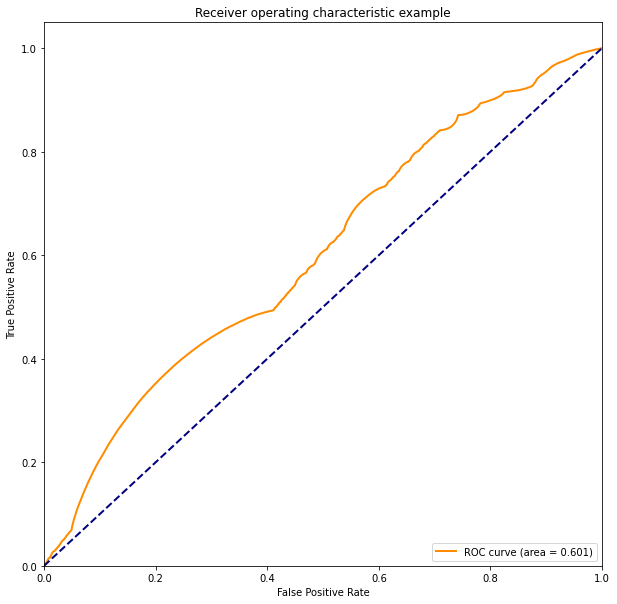

In [64]:
from sklearn.metrics import roc_curve, auc  ###计算roc和auc
import matplotlib.pyplot as plt

def acu_curve(y,prob):
    fpr,tpr,threshold = roc_curve(y,prob) ###计算真正率和假正率
    roc_auc = auc(fpr,tpr) ###计算auc的值
 
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
 
    plt.show()
acu_curve(y_val.values, pred_ans)

In [65]:
'''
import riiideducation
env = riiideducation.make_env()
iter_test = env.iter_test()

for (test_df, sample_prediction_df) in iter_test:
    test_df['task_container_id'] = test_df.task_container_id.mask(test_df.task_container_id > 9999, 9999)
    test_df = pd.merge(test_df, group3, left_on=['task_container_id'], right_index= True, how="left")
    test_df = pd.merge(test_df, question2, left_on = 'content_id', right_on = 'question_id', how = 'left')
    test_df = pd.merge(test_df, results_u_final, on=['user_id'],  how="left")
    test_df = pd.merge(test_df, results_u2_final, on=['user_id'],  how="left")
    
    test_df = pd.merge(test_df, user_lecture_stats_part, on=['user_id'], how="left")
    test_df['part_1'].fillna(0, inplace = True)
    test_df['part_2'].fillna(0, inplace = True)
    test_df['part_3'].fillna(0, inplace = True)
    test_df['part_4'].fillna(0, inplace = True)
    test_df['part_5'].fillna(0, inplace = True)
    test_df['part_6'].fillna(0, inplace = True)
    test_df['part_7'].fillna(0, inplace = True)
    test_df['type_of_concept'].fillna(0, inplace = True)
    test_df['type_of_intention'].fillna(0, inplace = True)
    test_df['type_of_solving_question'].fillna(0, inplace = True)
    test_df['type_of_starter'].fillna(0, inplace = True)
    test_df['part_1_boolean'].fillna(0, inplace = True)
    test_df['part_2_boolean'].fillna(0, inplace = True)
    test_df['part_3_boolean'].fillna(0, inplace = True)
    test_df['part_4_boolean'].fillna(0, inplace = True)
    test_df['part_5_boolean'].fillna(0, inplace = True)
    test_df['part_6_boolean'].fillna(0, inplace = True)
    test_df['part_7_boolean'].fillna(0, inplace = True)
    test_df['type_of_concept_boolean'].fillna(0, inplace = True)
    test_df['type_of_intention_boolean'].fillna(0, inplace = True)
    test_df['type_of_solving_question_boolean'].fillna(0, inplace = True)
    test_df['type_of_starter_boolean'].fillna(0, inplace = True)
    
    test_df['answered_correctly_user'].fillna(0.65,  inplace=True)
    test_df['explanation_mean_user'].fillna(prior_mean_user,  inplace=True)
    test_df['quest_pct'].fillna(content_mean,  inplace=True)
    test_df['part'] = test_df.part - 1

    test_df['part'].fillna(4, inplace = True)
    test_df['avg_questions_seen'].fillna(1, inplace = True)
    test_df['prior_question_elapsed_time'].fillna(elapsed_mean, inplace = True)
    test_df['prior_question_had_explanation'].fillna(False, inplace=True)
    test_df["prior_question_had_explanation_enc"] = lb_make.fit_transform(test_df["prior_question_had_explanation"])
    
    X = test_df[['answered_correctly_user', 'explanation_mean_user', 'quest_pct', 'avg_questions_seen',
                                                            'prior_question_elapsed_time','prior_question_had_explanation_enc', 'part',
                                                            'part_1', 'part_2', 'part_3', 'part_4', 'part_5', 'part_6', 'part_7',
                                                            'type_of_concept', 'type_of_intention', 'type_of_solving_question', 'type_of_starter',
                                                            'part_1_boolean', 'part_2_boolean', 'part_3_boolean', 'part_4_boolean', 'part_5_boolean', 'part_6_boolean', 'part_7_boolean',
                                                            'type_of_concept_boolean', 'type_of_intention_boolean', 'type_of_solving_question_boolean', 'type_of_starter_boolean']]
    for col in cat_columns + cont_columns:
        X[col] = scaler.fit_transoform(X[col].values.reshape(-1,1))
        
     fixlen_feature_columns = [SparseFeat(feat, X[feat].nunique())
                          for feat in cat_columns] + [DenseFeat(feat, 1, )
                                                      for feat in cont_columns]
    
    feature_names = get_feature_names(fixlen_feature_columns)
    
    test_model_input = {name: X[name] for name in feature_names}

    test_df['answered_correctly'] = model.predict(test_model_input, 256)

    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])

'''

'\nimport riiideducation\nenv = riiideducation.make_env()\niter_test = env.iter_test()\n\nfor (test_df, sample_prediction_df) in iter_test:\n    test_df[\'task_container_id\'] = test_df.task_container_id.mask(test_df.task_container_id > 9999, 9999)\n    test_df = pd.merge(test_df, group3, left_on=[\'task_container_id\'], right_index= True, how="left")\n    test_df = pd.merge(test_df, question2, left_on = \'content_id\', right_on = \'question_id\', how = \'left\')\n    test_df = pd.merge(test_df, results_u_final, on=[\'user_id\'],  how="left")\n    test_df = pd.merge(test_df, results_u2_final, on=[\'user_id\'],  how="left")\n    \n    test_df = pd.merge(test_df, user_lecture_stats_part, on=[\'user_id\'], how="left")\n    test_df[\'part_1\'].fillna(0, inplace = True)\n    test_df[\'part_2\'].fillna(0, inplace = True)\n    test_df[\'part_3\'].fillna(0, inplace = True)\n    test_df[\'part_4\'].fillna(0, inplace = True)\n    test_df[\'part_5\'].fillna(0, inplace = True)\n    test_df[\'part_